In [1]:
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as mtplt
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.tokenize import word_tokenize
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from wordcloud import WordCloud, STOPWORDS
import chardet
pyLDAvis.enable_notebook()
import string
import re
import math

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\divya\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
C:\Users\divya\AppData\Local\Programs\Python\Python310\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.8) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [2]:
with open('../data/nlp_vader_textblob_classified_data.csv', 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
    
tweetData = pd.read_csv('../data/nlp_vader_textblob_classified_data.csv', encoding = enc['encoding'], index_col=False)
tweetData

NameError: name 'chardet' is not defined

In [ ]:
print("Shape of data =>",tweetData.shape)

Shape of data => (97398, 25)


In [ ]:
tweetData['content'].isnull().sum()

0

ManCity              25983
Manchester United    17802
Liverpool            15516
Chelsea              15239
Arsenal              14071
Tottenham             8787
Name: primaryTeam, dtype: int64


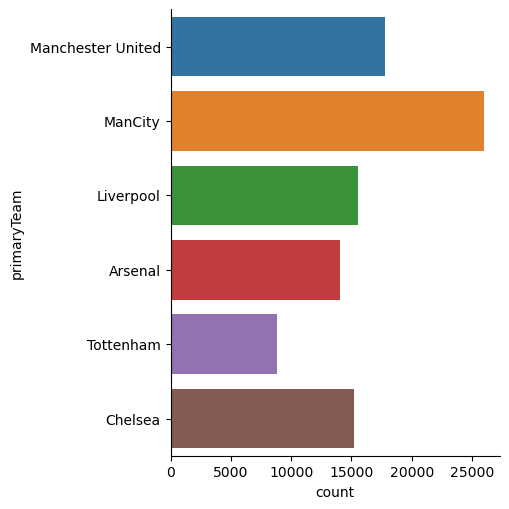

In [ ]:
print(tweetData["primaryTeam"].value_counts())
sb.catplot(y = "primaryTeam", data = tweetData, kind = "count")

In [ ]:
manuData = tweetData.loc[tweetData['primaryTeam'] == 'Manchester United']
mancData = tweetData.loc[tweetData['primaryTeam'] == 'ManCity']
chelseaData = tweetData.loc[tweetData['primaryTeam'] == 'Chelsea']
arsenalData = tweetData.loc[tweetData['primaryTeam'] == 'Arsenal']
liverpoolData = tweetData.loc[tweetData['primaryTeam'] == 'Liverpool']
totData = tweetData.loc[tweetData['primaryTeam'] == 'Tottenham']

## Overall Stats

<AxesSubplot:>

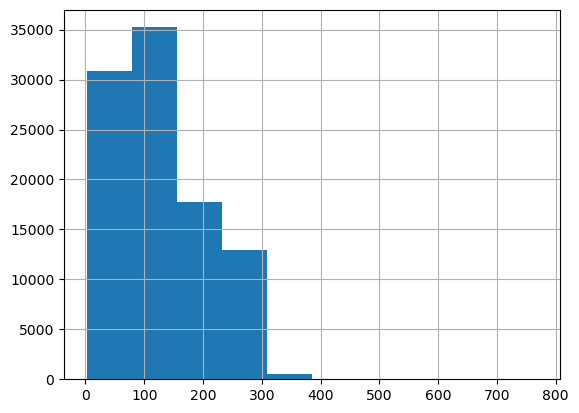

In [ ]:
tweetData['content'].str.len().hist()

<AxesSubplot:>

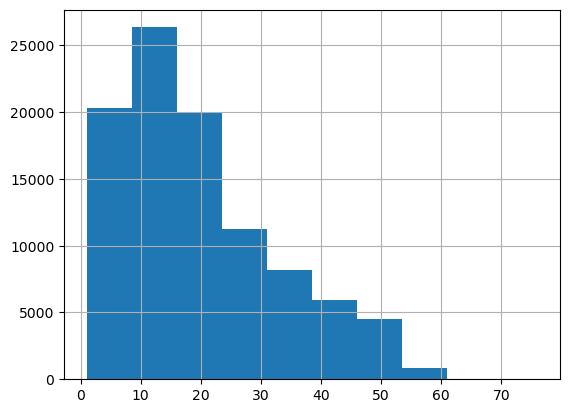

In [ ]:
tweetData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

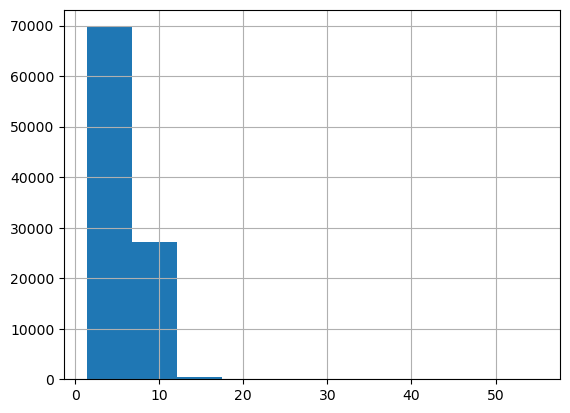

In [ ]:
tweetData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [ ]:
stop=set(stopwords.words('english'))

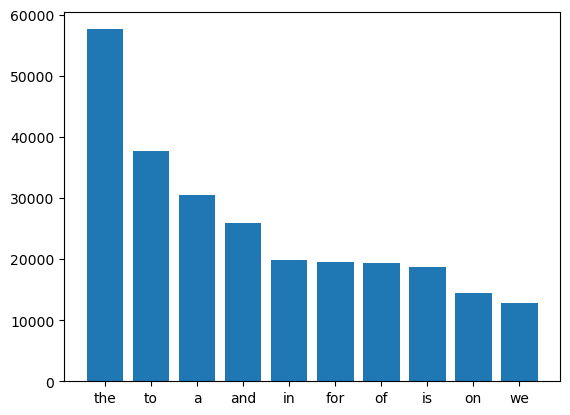

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= tweetData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

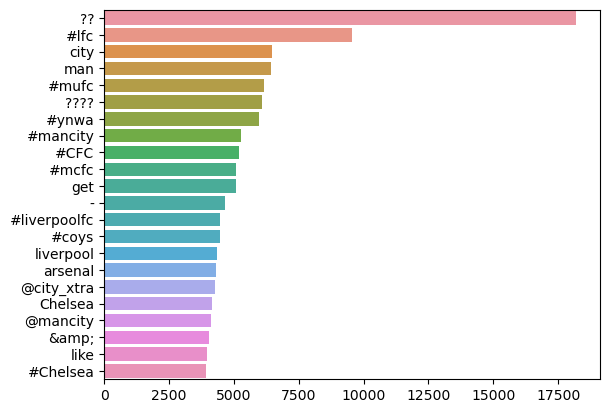

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sb.barplot(x=y,y=x)

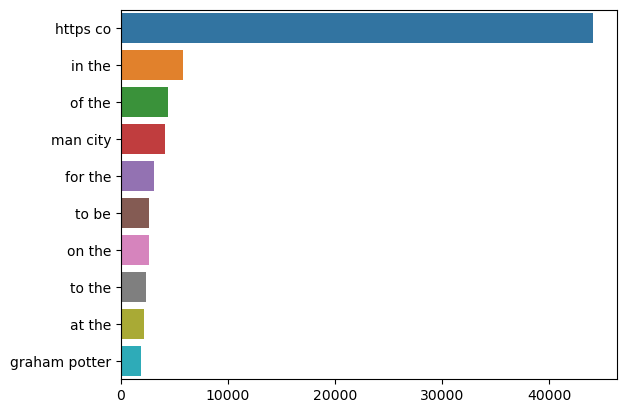

In [ ]:
plot_top_ngrams_barchart(tweetData['content'],2)

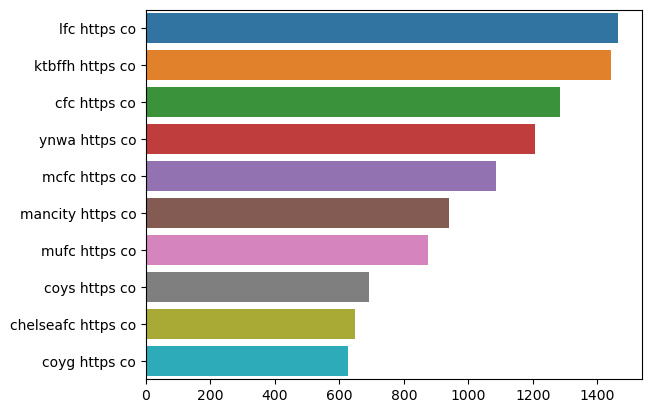

In [ ]:
plot_top_ngrams_barchart(tweetData['content'],3)

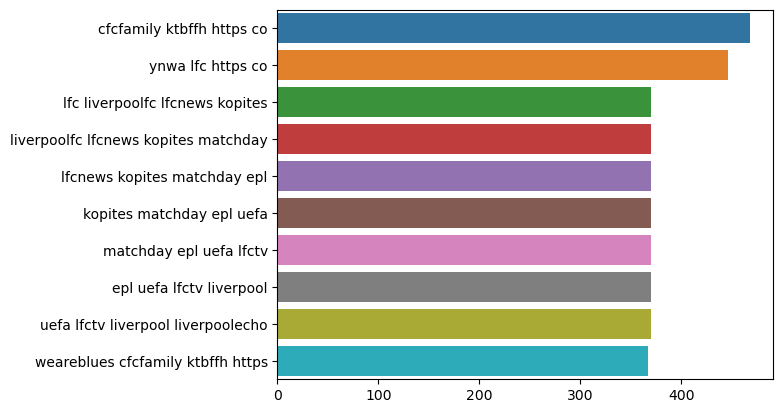

In [ ]:
plot_top_ngrams_barchart(tweetData['content'],4)

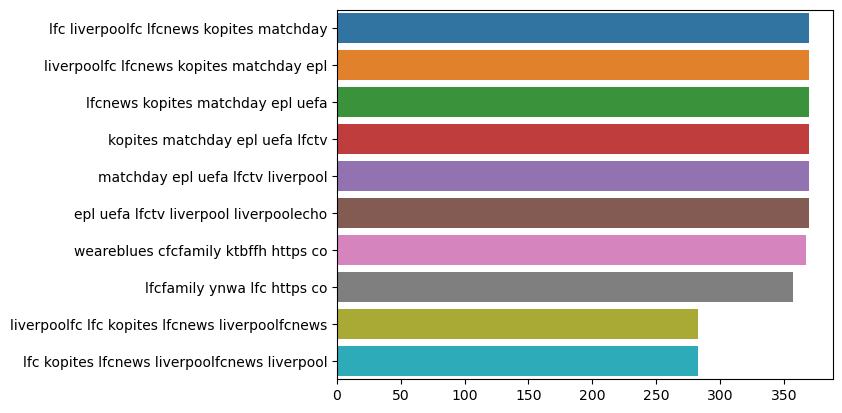

In [ ]:
plot_top_ngrams_barchart(tweetData['content'],5)

In [ ]:
# The output of the following cells are interactable - to give a better idea of the dataset
def get_lda_objects(text):
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')
    stop=set(stopwords.words('english'))

    
    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    dic=gensim.corpora.Dictionary(corpus)
    bow_corpus = [dic.doc2bow(doc) for doc in corpus]
    
    lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 10, 
                                   id2word = dic,                                    
                                   passes = 10,
                                   workers = 2)
    
    return lda_model, bow_corpus, dic

def plot_lda_vis(lda_model, bow_corpus, dic):
    vis = gensimvis.prepare(lda_model, bow_corpus, dic)
    return vis

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(tweetData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.028*"kane" + 0.019*"harry" + 0.015*"glazersout" + 0.012*"http" + 0.009*"mufc" + 0.009*"press" + 0.008*"munliv" + 0.007*"manutd" + 0.007*"wow" + 0.007*"conference"'),
 (1,
  '0.085*"http" + 0.050*"coys" + 0.049*"lfc" + 0.030*"ynwa" + 0.028*"thfc" + 0.024*"cfc" + 0.018*"liverpool" + 0.015*"liverpoolfc" + 0.011*"mancity" + 0.010*"anfield"'),
 (2,
  '0.043*"http" + 0.014*"amp" + 0.012*"arsmun" + 0.010*"luck" + 0.010*"COYB" + 0.009*"totful" + 0.008*"new" + 0.008*"Good" + 0.008*"good" + 0.008*"CHELSEA"'),
 (3,
  '0.043*"goal" + 0.024*"half" + 0.016*"ball" + 0.015*"score" + 0.013*"first" + 0.012*"second" + 0.010*"minute" + 0.008*"2nd" + 0.007*"fucking" + 0.007*"player"'),
 (4,
  '0.084*"Chelsea" + 0.060*"http" + 0.049*"CFC" + 0.046*"ChelseaFC" + 0.027*"Tuchel" + 0.027*"KTBFFH" + 0.027*"Potter" + 0.017*"Graham" + 0.012*"manager" + 0.010*"new"'),
 (5,
  '0.040*"city_xtra" + 0.011*"Coach" + 0.011*"romero" + 0.010*"mancity" + 0.009*"footballtransfers" + 0.009*"erlinghaaland" + 0.009*"He

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.263785 -0.153030       1        1  19.430405
7      0.231268 -0.063848       2        1  17.885448
1      0.082160  0.141008       3        1  14.303116
4      0.092255  0.200487       4        1  11.131553
8     -0.025778  0.163651       5        1   9.957943
6     -0.105903  0.117243       6        1   8.357846
3      0.010045 -0.237588       7        1   5.868129
2     -0.092764  0.054772       8        1   5.322472
5     -0.203632 -0.143063       9        1   3.939331
0     -0.251434 -0.079632      10        1   3.803757, topic_info=               Term          Freq         Total Category  logprob  loglift
87377       Chelsea  11693.000000  11693.000000  Default  30.0000  30.0000
47             http  47548.000000  47548.000000  Default  29.0000  29.0000
3046           coys   8980.000000   8980.000000  Default  28.0000  28.0000
711             lfc   9981.000000   9981.000000  Default  27.0000  27.0000
87393           CFC   6831.000000   6831.000000  Default  26.0000  26.0000
...             ...           ...           ...      ...      ...      ...
33             mufc    448.262932   2573.121254  Topic10  -4.6633   1.5217
32           manutd    327.887186   1666.868831  Topic10  -4.9761   1.6431
442           found    167.678650    254.777485  Topic10  -5.6467   2.8508
47             http    572.282993  47548.101815  Topic10  -4.4191  -1.1507
377    utdfaithfuls    145.431828    300.941144  Topic10  -5.7890   2.5420

[554 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
316       1  0.365661      ...
316       2  0.208911      ...
316       3  0.240207      ...
316       4  0.103787      ...
316       5  0.048148      ...
...     ...       ...      ...
176       4  0.059279     year
176       6  0.001170     year
176       9  0.001950     year
699       3  0.999775     ynwa
159       5  0.997101  youtube

[931 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 2, 5, 9, 7, 4, 3, 6, 1])

In [ ]:
def plot_wordcloud(text):
    nltk.download('stopwords')
    stop=set(stopwords.words('english'))

    def _preprocess_text(text):
        corpus=[]
        stem=PorterStemmer()
        lem=WordNetLemmatizer()
        for news in text:
            words=[w for w in word_tokenize(news) if (w not in stop)]

            words=[lem.lemmatize(w) for w in words if len(w)>2]

            corpus.append(words)
        return corpus
    
    corpus=_preprocess_text(text)
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=set(STOPWORDS),
        max_words=100,
        max_font_size=30, 
        scale=3,
        random_state=1)
    
    wordcloud=wordcloud.generate(str(corpus))

    fig = mtplt.figure(1, figsize=(12, 12))
    mtplt.axis('off')
 
    mtplt.imshow(wordcloud)
    mtplt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


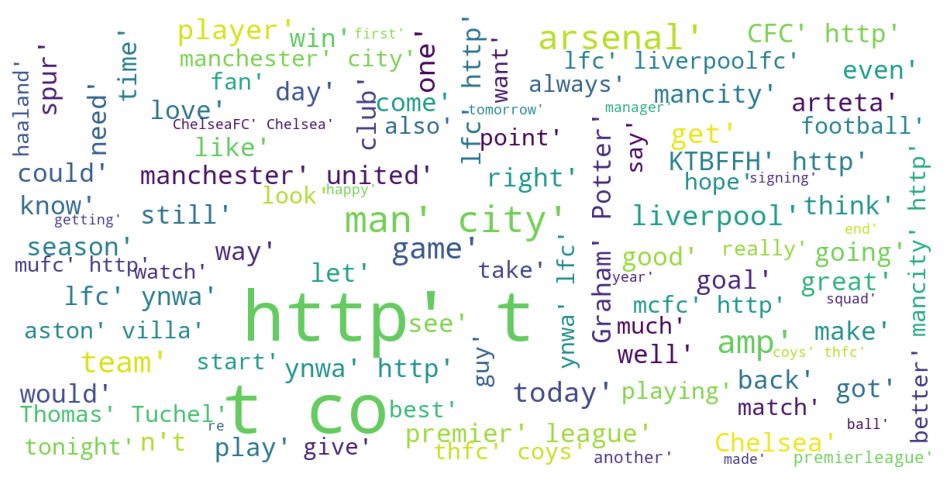

In [ ]:
plot_wordcloud(tweetData['content'])

False    93080
True      4318
Name: verified, dtype: int64


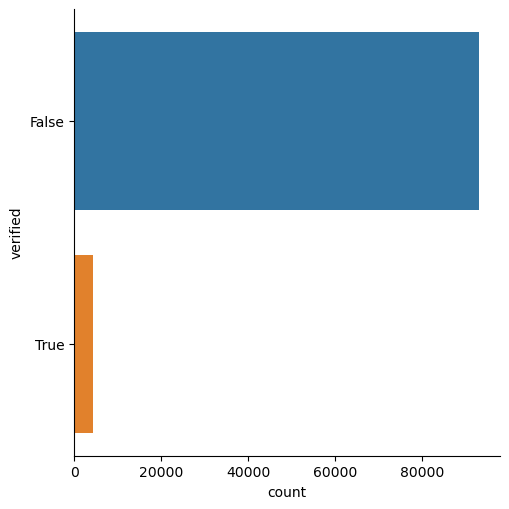

In [ ]:
print(tweetData["verified"].value_counts())
sb.catplot(y = "verified", data = tweetData, kind = "count")

Argentina              35425
United States          19731
India                  11085
Zimbabwe                6781
Denmark                 6675
Australia               5775
Brazil                  2436
South Africa            2423
Kenya                   1157
New Zealand             1001
Germany                  692
Singapore                617
Ireland                  516
Egypt                    509
Japan                    421
Belgium                  288
France                   223
United Kingdom           222
Uruguay                  195
Mexico                   190
Norway                   170
South Korea              149
Sweden                   143
Italy                    132
Canada                    96
Switzerland               83
Nigeria                   79
Spain                     50
Trinidad and Tobago       49
Peru                      39
Croatia                   23
Netherlands               21
Portugal                   1
El Salvador                1
Name: country,

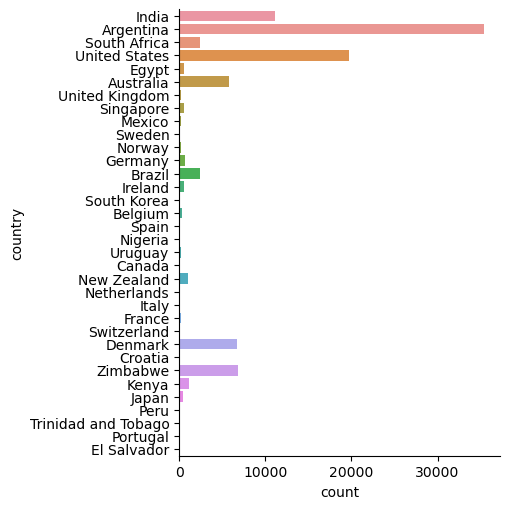

In [ ]:
print(tweetData["country"].value_counts())
sb.catplot(y = "country", data = tweetData, kind = "count")

 1    35030
 0    31549
-1    30819
Name: final_class, dtype: int64


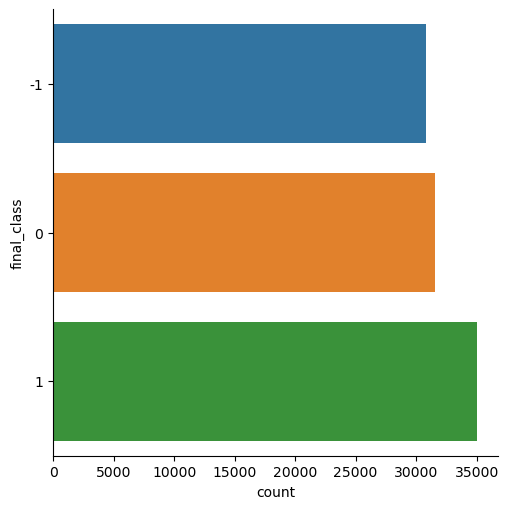

In [ ]:
print(tweetData["final_class"].value_counts())
sb.catplot(y = "final_class", data = tweetData, kind = "count")

## Manchester United

<AxesSubplot:>

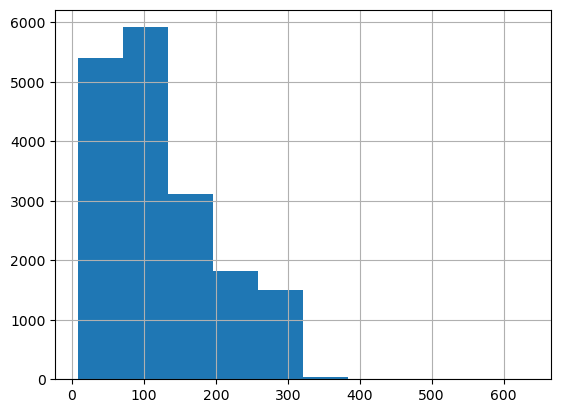

In [ ]:
manuData['content'].str.len().hist()

<AxesSubplot:>

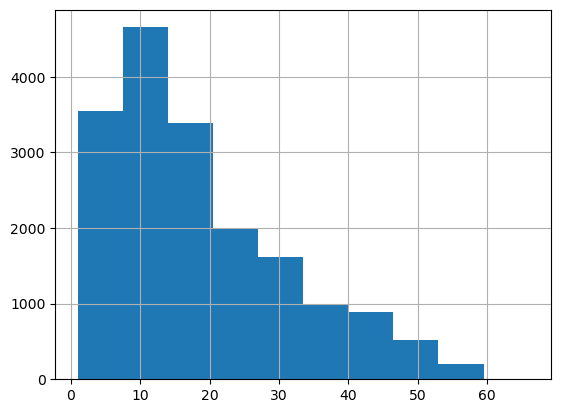

In [ ]:
manuData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

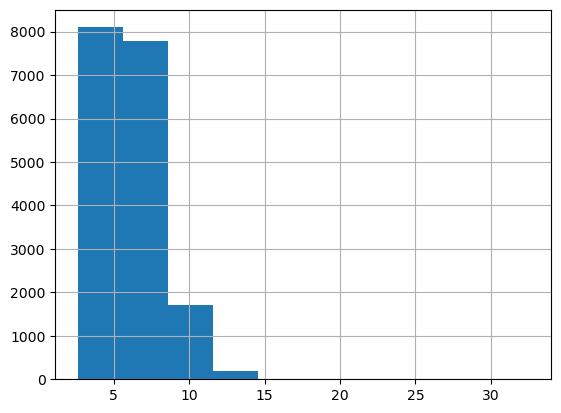

In [ ]:
manuData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

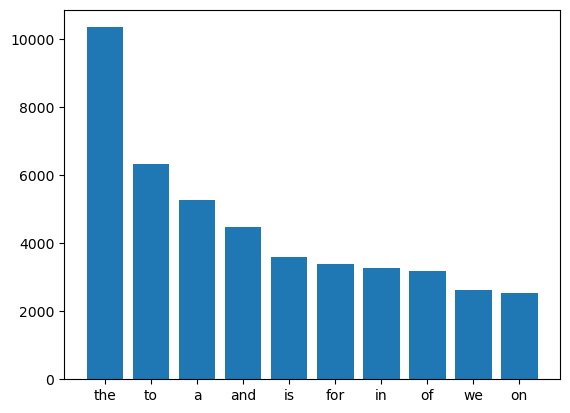

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= manuData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

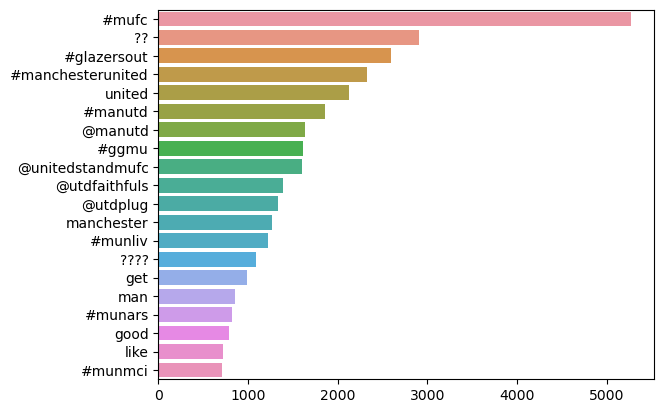

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
    stop=set(stopwords.words('english'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sb.barplot(x=y,y=x)

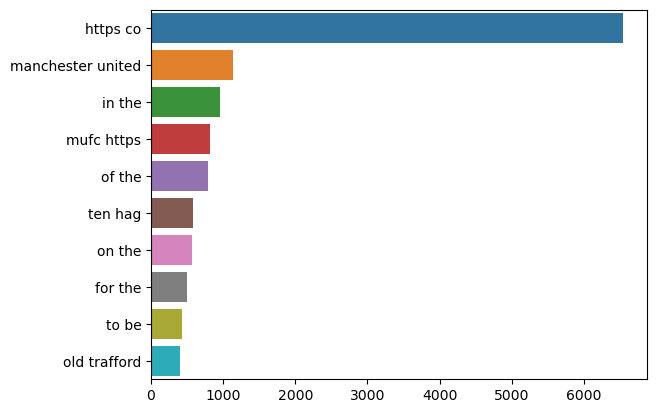

In [ ]:
plot_top_ngrams_barchart(manuData['content'],2)

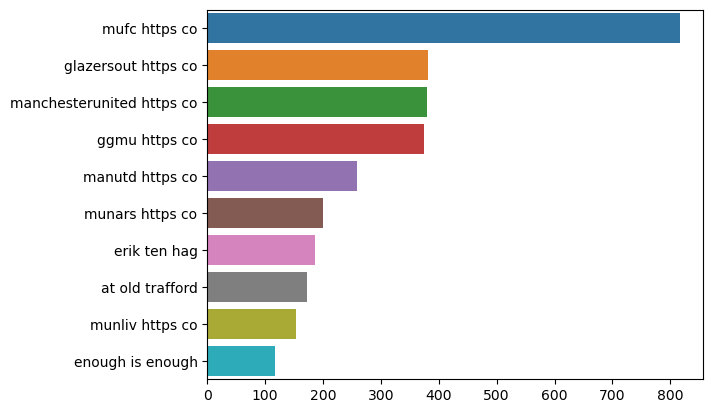

In [ ]:
plot_top_ngrams_barchart(manuData['content'],3)

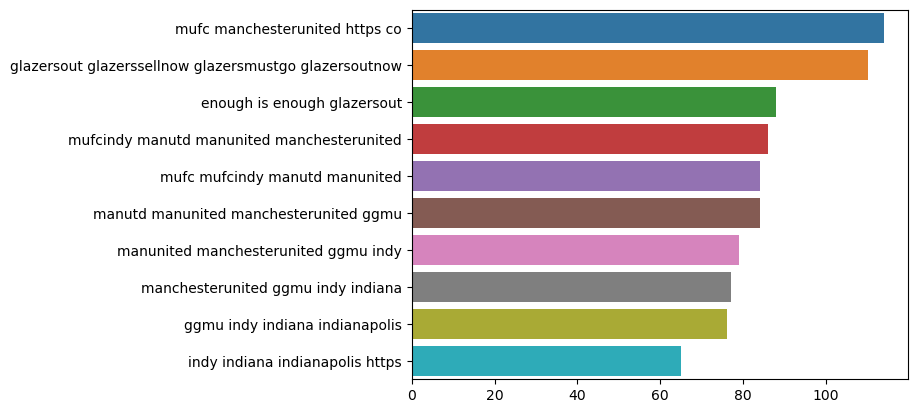

In [ ]:
plot_top_ngrams_barchart(manuData['content'],4)

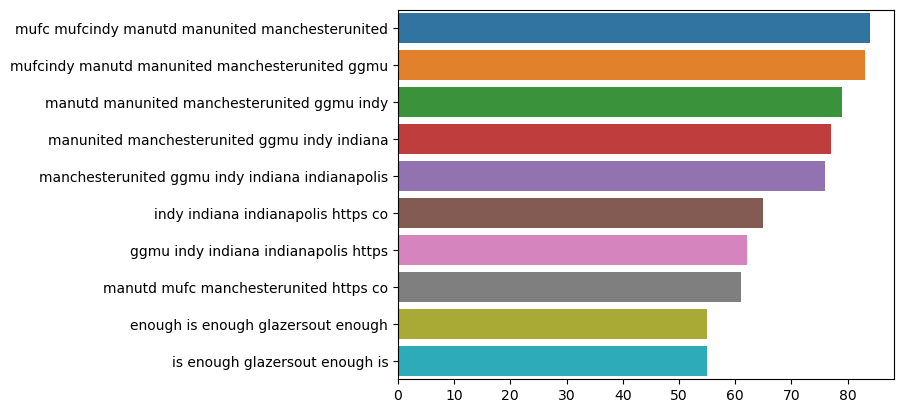

In [ ]:
plot_top_ngrams_barchart(manuData['content'],5)

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(manuData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.043*"glazersout" + 0.033*"manutd" + 0.019*"http" + 0.018*"antony00" + 0.017*"club" + 0.014*"glazerssellmanutd" + 0.010*"mufc" + 0.010*"unitedstandmufc" + 0.009*"lisandrmartinez" + 0.009*"utdfaithfuls"'),
 (1,
  '0.045*"mufc" + 0.040*"http" + 0.039*"ronaldo" + 0.021*"cristiano" + 0.017*"cr7" + 0.015*"win" + 0.015*"muntot" + 0.013*"manchesterunited" + 0.012*"goal" + 0.012*"sancho"'),
 (2,
  '0.052*"http" + 0.044*"mufc" + 0.036*"manchesterunited" + 0.035*"united" + 0.030*"manutd" + 0.029*"antony" + 0.018*"munliv" + 0.017*"manchester" + 0.010*"ajax" + 0.009*"please"'),
 (3,
  '0.043*"http" + 0.022*"league" + 0.019*"mufc" + 0.011*"premier" + 0.011*"munars" + 0.010*"utdplug" + 0.010*"united" + 0.007*"weareunited" + 0.006*"amp" + 0.006*"manchester"'),
 (4,
  '0.031*"glazersout" + 0.028*"utdplug" + 0.018*"unitedstandmufc" + 0.015*"player" + 0.015*"glazer" + 0.014*"enough" + 0.013*"n\'t" + 0.013*"club" + 0.011*"http" + 0.011*"lauriewhitwell"'),
 (5,
  '0.072*"http" + 0.041*"ggmu" + 0.

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.086128 -0.188819       1        1  17.270849
4     -0.196130  0.013812       2        1  13.007643
7      0.044146 -0.136861       3        1  12.926232
5      0.217445  0.076911       4        1  10.706641
6      0.080009 -0.006317       5        1   9.480683
2      0.111096  0.124718       6        1   9.074985
1      0.113600 -0.087660       7        1   7.918821
9     -0.211885  0.051201       8        1   6.997720
0     -0.148822  0.126437       9        1   6.383452
3      0.076670  0.026578      10        1   6.232975, topic_info=                 Term         Freq        Total Category  logprob  loglift
137        glazersout  2352.000000  2352.000000  Default  30.0000  30.0000
47               http  5905.000000  5905.000000  Default  29.0000  29.0000
69            ronaldo   882.000000   882.000000  Default  28.0000  28.0000
81   manchesterunited  2162.000000  2162.000000  Default  27.0000  27.0000
20    unitedstandmufc  1507.000000  1507.000000  Default  26.0000  26.0000
..                ...          ...          ...      ...      ...      ...
81   manchesterunited    48.623287  2162.429387  Topic10  -5.5973  -1.0196
79                man    38.805175   844.345890  Topic10  -5.8228  -0.3047
176              year    34.977037   326.559004  Topic10  -5.9267   0.5414
6                 get    36.156839  1016.812615  Topic10  -5.8935  -0.5612
285         liverpool    33.758939   441.922953  Topic10  -5.9622   0.2034

[748 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
316       1  0.282387      ...
316       2  0.259177      ...
316       3  0.131523      ...
316       4  0.040617      ...
316       5  0.063827      ...
...     ...       ...      ...
159      10  0.061408  youtube
604       6  0.985297   zayden
605       6  0.944365   zayzay
1889      9  0.980814     zero
1443      6  0.954419    €100m

[1637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 8, 6, 7, 3, 2, 10, 1, 4])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


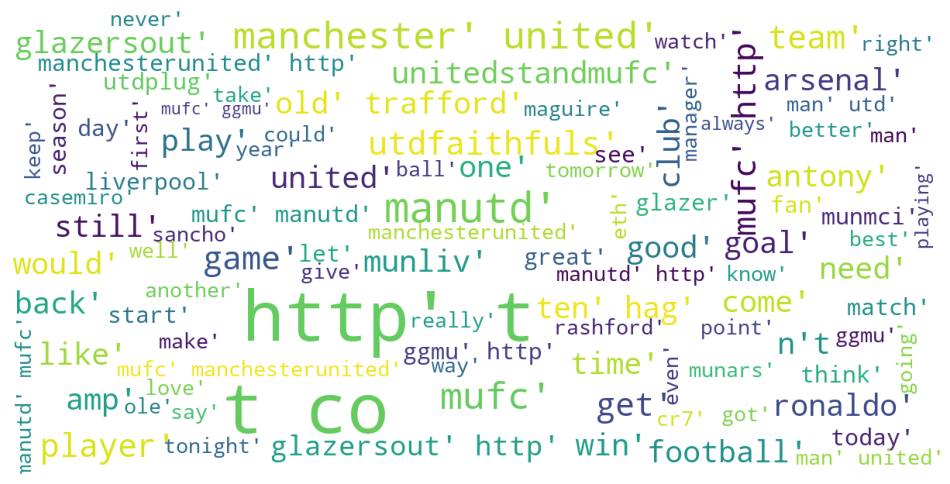

In [ ]:
plot_wordcloud(manuData['content'])

False    17287
True       515
Name: verified, dtype: int64


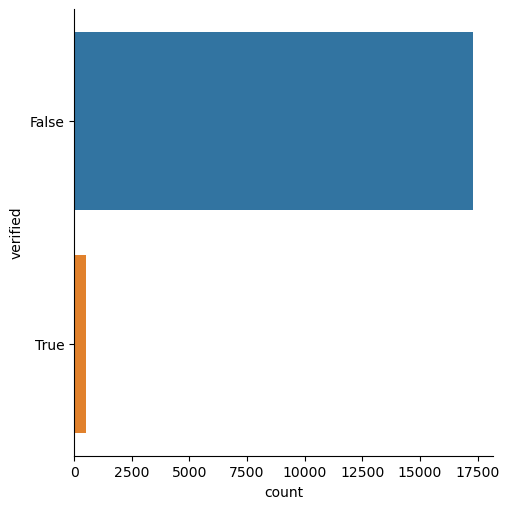

In [ ]:
print(manuData["verified"].value_counts())
sb.catplot(y = "verified", data = manuData, kind = "count")

Argentina         6231
United States     4329
India             3412
South Africa       576
Ireland            492
Australia          491
Brazil             464
Egypt              429
Singapore          353
Belgium            200
Norway             161
United Kingdom     146
Sweden             103
Mexico              82
Nigeria             77
Germany             61
South Korea         57
Spain               50
Uruguay             47
Netherlands         18
Canada              14
New Zealand          8
Italy                1
Name: country, dtype: int64


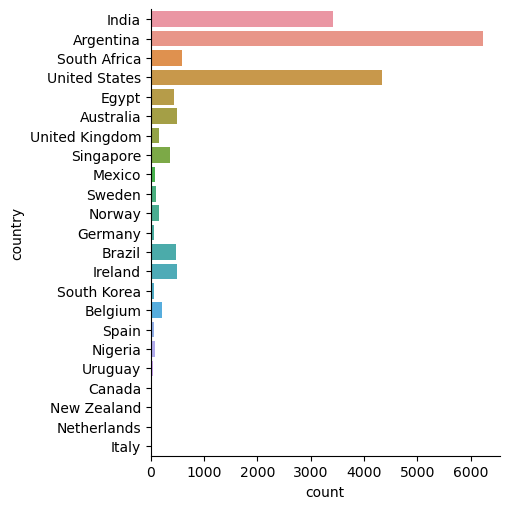

In [ ]:
print(manuData["country"].value_counts())
sb.catplot(y = "country", data = manuData, kind = "count")

 1    6987
-1    5529
 0    5286
Name: final_class, dtype: int64


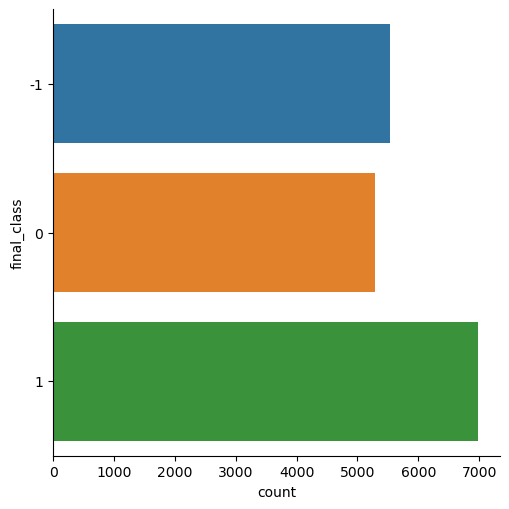

In [ ]:
print(manuData["final_class"].value_counts())
sb.catplot(y = "final_class", data = manuData, kind = "count")

## Manchester City

<AxesSubplot:>

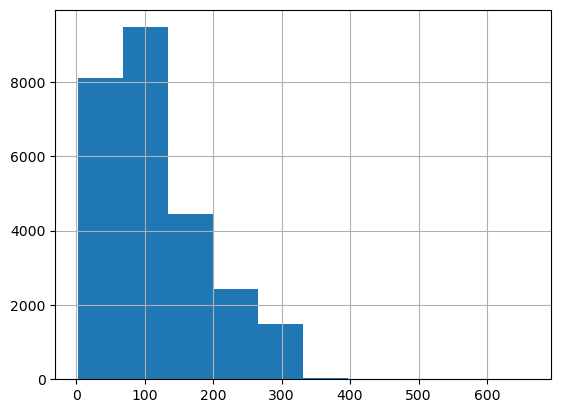

In [ ]:
mancData['content'].str.len().hist()

<AxesSubplot:>

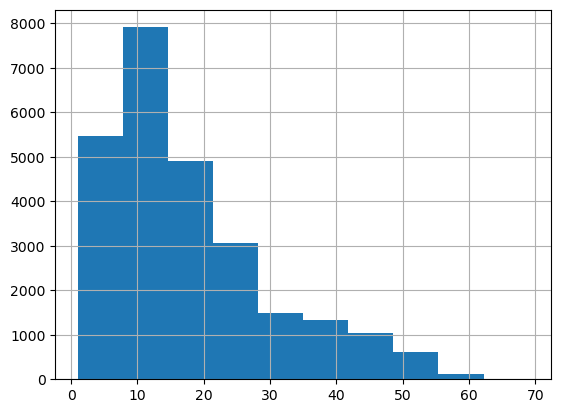

In [ ]:
mancData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

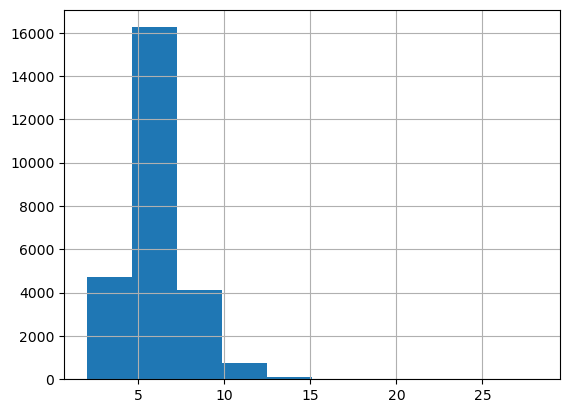

In [ ]:
mancData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

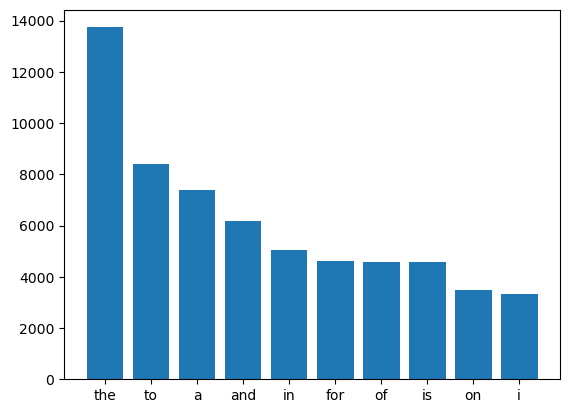

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= mancData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

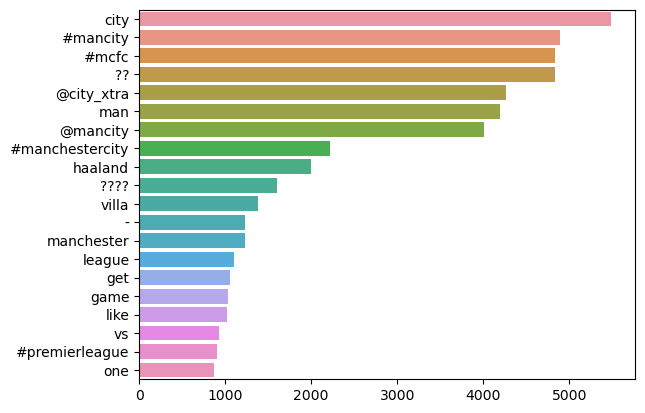

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

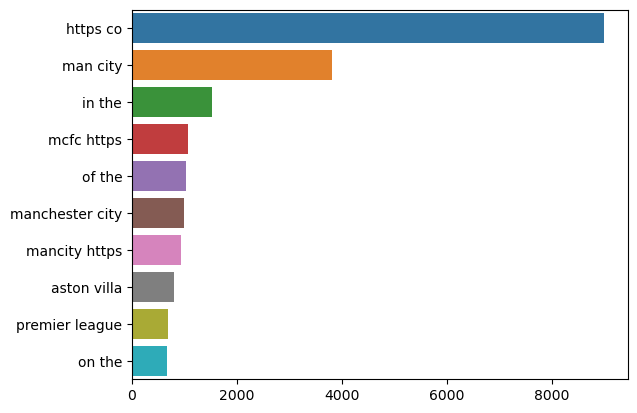

In [ ]:
plot_top_ngrams_barchart(mancData['content'],2)

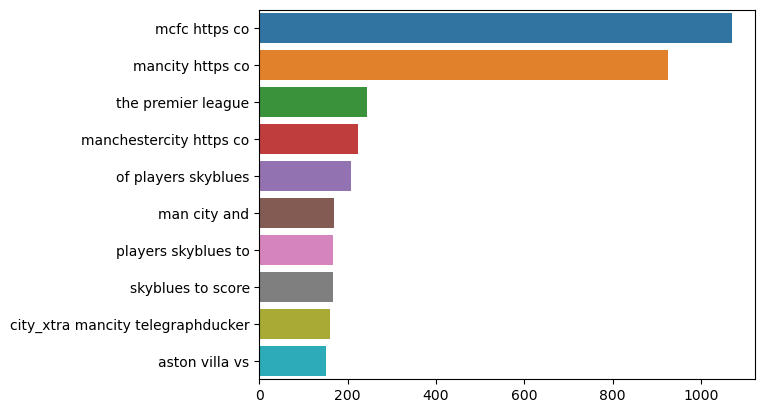

In [ ]:
plot_top_ngrams_barchart(mancData['content'],3)

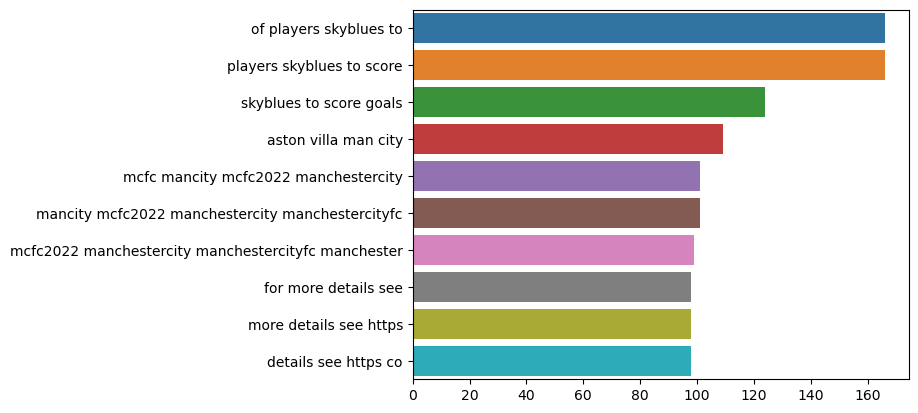

In [ ]:
plot_top_ngrams_barchart(mancData['content'],4)

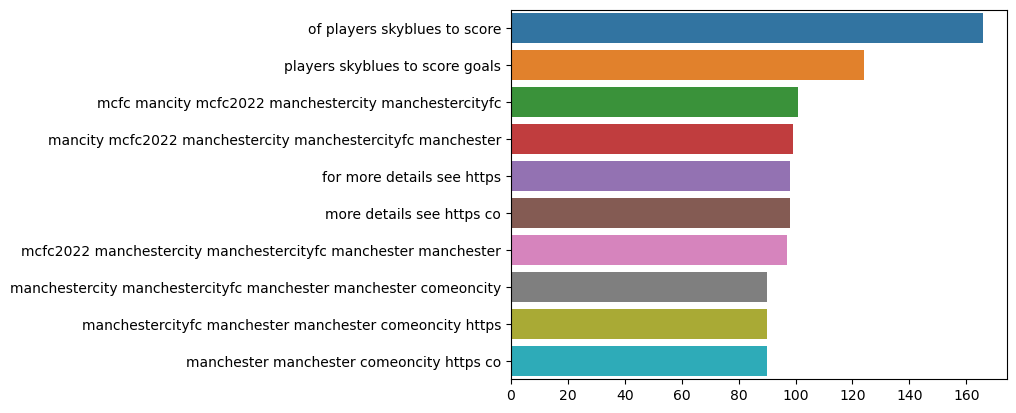

In [ ]:
plot_top_ngrams_barchart(mancData['content'],5)

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(mancData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.057*"mancity" + 0.040*"http" + 0.029*"mcfc" + 0.007*"game" + 0.007*"let" + 0.007*"amp" + 0.006*"manchestercity" + 0.006*"get" + 0.006*"football" + 0.005*"mancityus"'),
 (1,
  '0.064*"city" + 0.054*"man" + 0.044*"http" + 0.037*"villa" + 0.020*"aston" + 0.016*"mcfc" + 0.015*"liverpool" + 0.012*"avfc" + 0.012*"arsenal" + 0.009*"chelsea"'),
 (2,
  '0.040*"http" + 0.033*"city" + 0.021*"manchestercity" + 0.020*"mcfc" + 0.019*"manchester" + 0.018*"forest" + 0.016*"mancity" + 0.016*"goal" + 0.015*"score" + 0.015*"player"'),
 (3,
  '0.028*"mancity" + 0.019*"city_xtra" + 0.012*"like" + 0.010*"mcfc_lads" + 0.009*"lfc" + 0.007*"play" + 0.007*"get" + 0.007*"avfcofficial" + 0.006*"time" + 0.005*"indykaila"'),
 (4,
  '0.111*"city_xtra" + 0.017*"erlinghaaland" + 0.014*"n\'t" + 0.013*"statcity" + 0.011*"footballdaily" + 0.009*"would" + 0.009*"bernardo" + 0.008*"walker" + 0.008*"play" + 0.007*"get"'),
 (5,
  '0.046*"mancity" + 0.021*"city" + 0.018*"man" + 0.014*"city_xtra" + 0.013*"point" + 0.

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.038685 -0.035097       1        1  17.647029
7      0.137284  0.148358       2        1  13.122969
1      0.194420 -0.185064       3        1  12.864535
8     -0.064698 -0.050817       4        1   9.696828
5     -0.066570 -0.091217       5        1   9.601949
0      0.044584  0.153646       6        1   8.586679
2      0.142876  0.017220       7        1   8.238444
4     -0.262227 -0.010653       8        1   7.606452
6     -0.055786  0.025169       9        1   6.805985
3     -0.108568  0.028455      10        1   5.829131, topic_info=          Term         Freq        Total Category  logprob  loglift
129  city_xtra  3904.000000  3904.000000  Default  30.0000  30.0000
3      haaland  2776.000000  2776.000000  Default  29.0000  29.0000
4      mancity  8769.000000  8769.000000  Default  28.0000  28.0000
83         man  4012.000000  4012.000000  Default  27.0000  27.0000
151      villa  1528.000000  1528.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
90        good    66.418433   878.771019  Topic10  -5.5542   0.2598
11        city    79.789372  6361.377005  Topic10  -5.3708  -1.5363
13        http    80.139509  8534.447340  Topic10  -5.3664  -1.8258
34        mcfc    72.785101  5061.728243  Topic10  -5.4626  -1.3996
61        goal    68.049638  1912.081142  Topic10  -5.5299  -0.4934

[773 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
1041      1  0.157684     're
1041      2  0.011538     're
1041      4  0.142300     're
1041      5  0.576893     're
1041      6  0.042305     're
...     ...       ...     ...
1987      5  0.207153     yes
1987      9  0.106232     yes
1987     10  0.435552     yes
1386      8  0.940654    £10m
2184      2  0.947105  €17.5m

[1819 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 2, 9, 6, 1, 3, 5, 7, 4])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


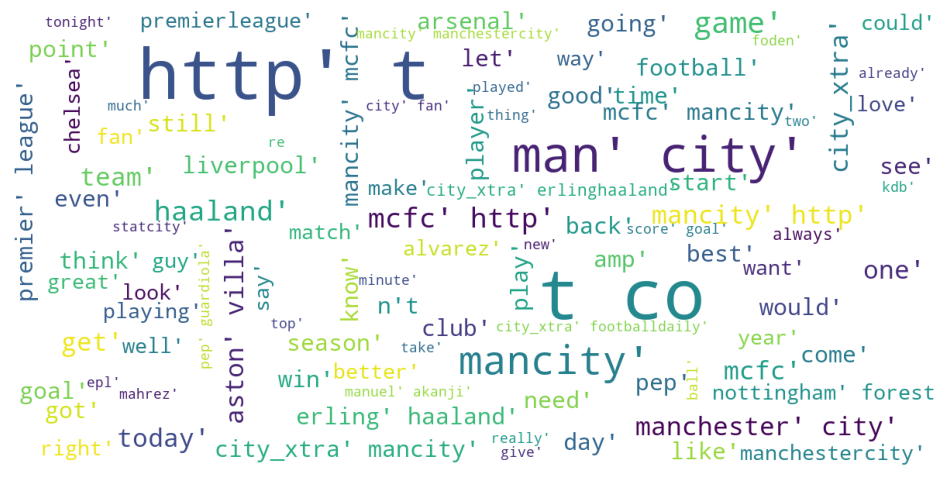

In [ ]:
plot_wordcloud(mancData['content'])

False    24546
True      1437
Name: verified, dtype: int64


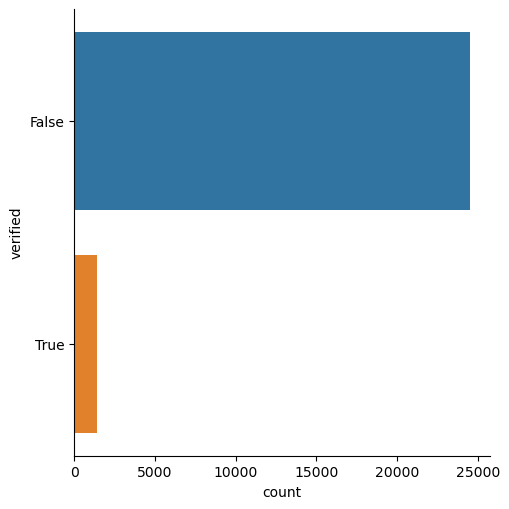

In [ ]:
print(mancData["verified"].value_counts())
sb.catplot(y = "verified", data = mancData, kind = "count")

Denmark          6675
Argentina        6259
Australia        4345
United States    4234
India            1755
South Africa     1044
Brazil            790
France            191
Singapore         126
Italy             102
Uruguay            90
Belgium            85
Switzerland        83
Canada             74
Mexico             55
South Korea        46
Croatia            23
New Zealand         4
Netherlands         2
Name: country, dtype: int64


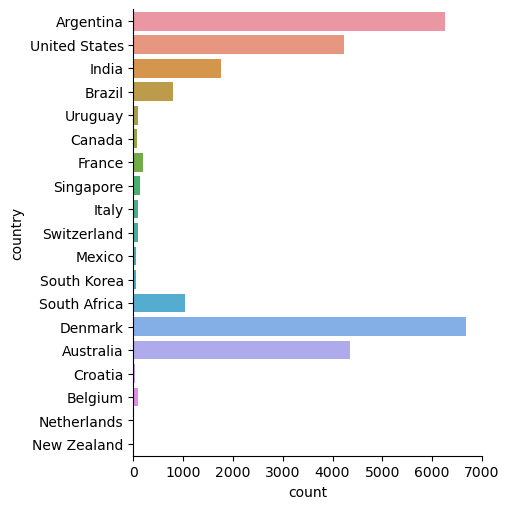

In [ ]:
print(mancData["country"].value_counts())
sb.catplot(y = "country", data = mancData, kind = "count")

 0    9581
 1    8534
-1    7868
Name: final_class, dtype: int64


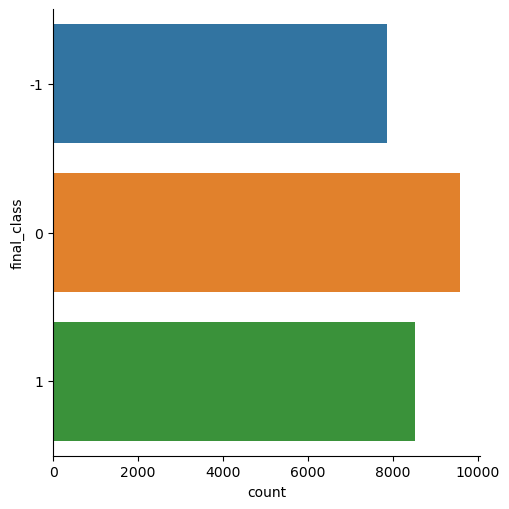

In [ ]:
print(mancData["final_class"].value_counts())
sb.catplot(y = "final_class", data = mancData, kind = "count")

## Chelsea

<AxesSubplot:>

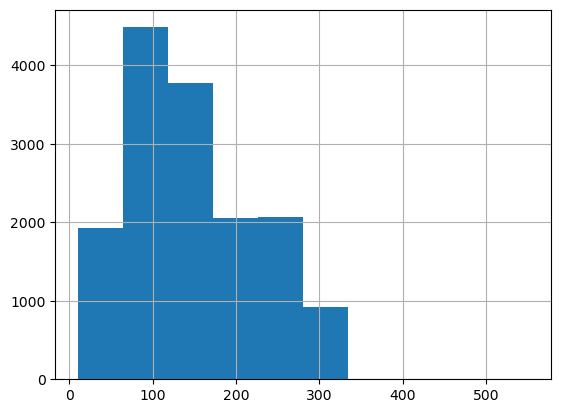

In [ ]:
chelseaData['content'].str.len().hist()

<AxesSubplot:>

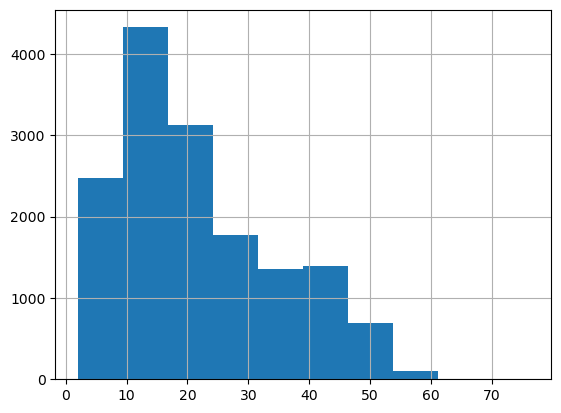

In [ ]:
chelseaData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

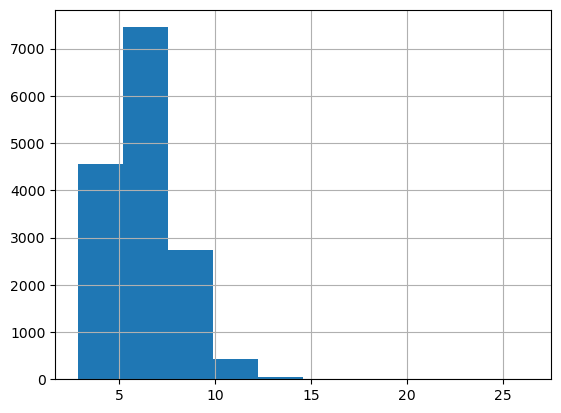

In [ ]:
chelseaData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

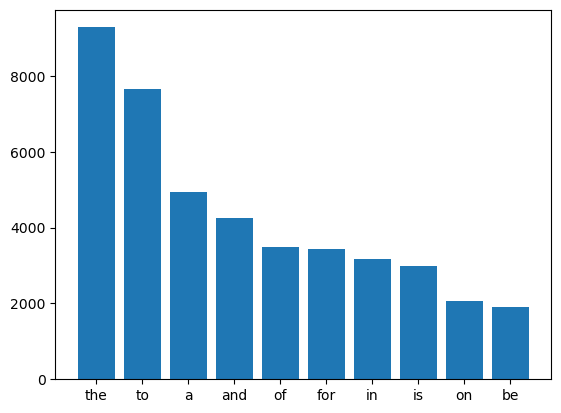

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= chelseaData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

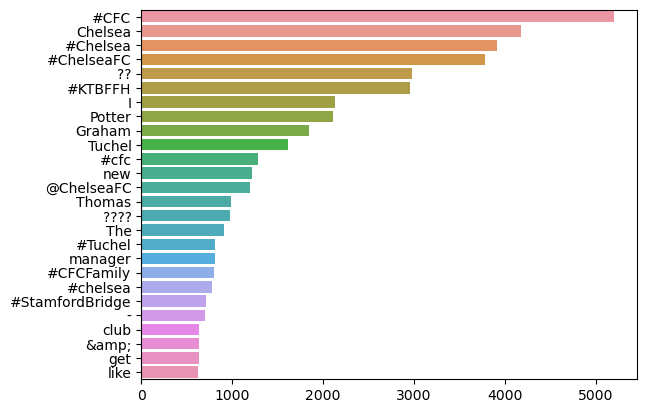

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

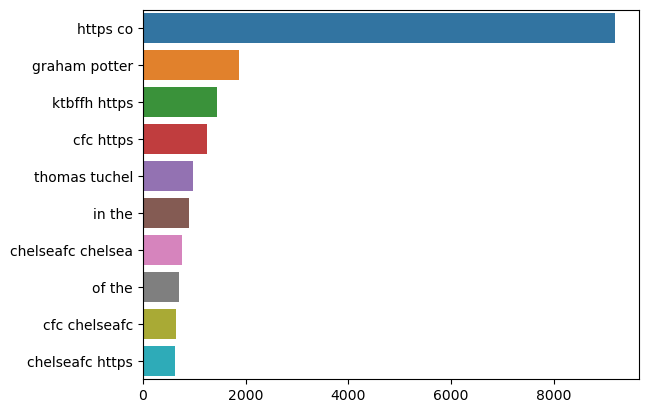

In [ ]:
plot_top_ngrams_barchart(chelseaData['content'],2)

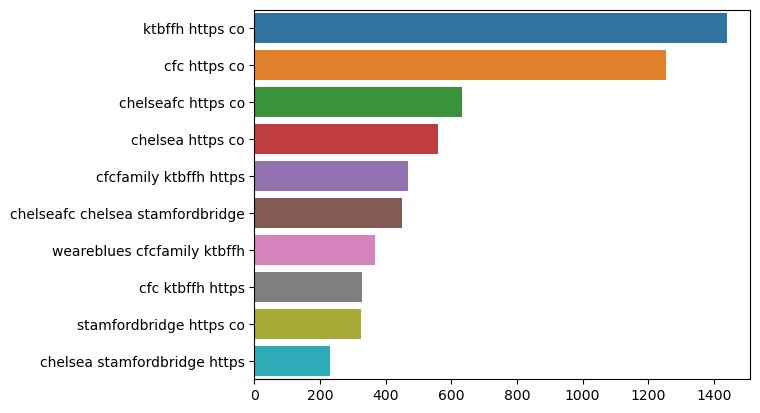

In [ ]:
plot_top_ngrams_barchart(chelseaData['content'],3)

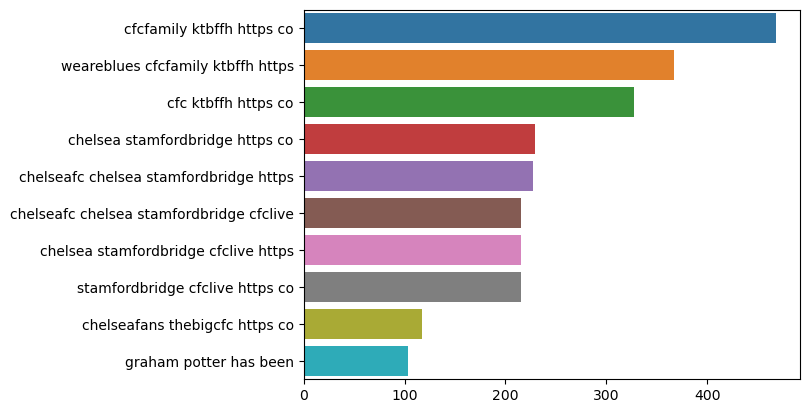

In [ ]:
plot_top_ngrams_barchart(chelseaData['content'],4)

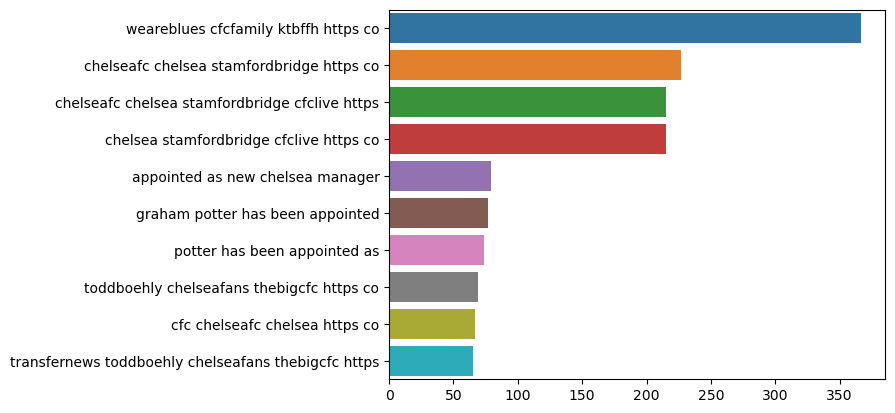

In [ ]:
plot_top_ngrams_barchart(chelseaData['content'],5)

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(chelseaData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.026*"http" + 0.026*"Chelsea" + 0.022*"Tuchel" + 0.021*"ChelseaFC" + 0.017*"CFC" + 0.012*"Thomas" + 0.011*"Potter" + 0.009*"Aubameyang" + 0.007*"sacking" + 0.005*"cfc"'),
 (1,
  '0.047*"http" + 0.033*"Chelsea" + 0.030*"ChelseaFC" + 0.024*"CFC" + 0.018*"KTBFFH" + 0.008*"cfc" + 0.006*"football" + 0.005*"Mount" + 0.005*"The" + 0.005*"CFCFamily"'),
 (2,
  '0.074*"Potter" + 0.052*"Graham" + 0.050*"Chelsea" + 0.038*"http" + 0.037*"new" + 0.034*"CFC" + 0.022*"manager" + 0.018*"ChelseaFC" + 0.015*"Welcome" + 0.013*"coach"'),
 (3,
  '0.044*"http" + 0.029*"ChelseaFC" + 0.029*"Chelsea" + 0.016*"chelseafans" + 0.013*"chelseafc" + 0.012*"CFC" + 0.011*"Bridge" + 0.011*"stamfordbridge" + 0.010*"Stamford" + 0.010*"KTBFFH"'),
 (4,
  '0.062*"http" + 0.026*"CFC" + 0.024*"Chelsea" + 0.021*"KTBFFH" + 0.015*"ChelseaFC" + 0.011*"chelsea" + 0.010*"cfc" + 0.008*"Come" + 0.008*"chelseafc" + 0.007*"Blues"'),
 (5,
  '0.043*"Chelsea" + 0.031*"http" + 0.024*"Tuchel" + 0.020*"CFC" + 0.019*"KTBFFH" + 0.015*"

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.053297  0.072489       1        1  28.324696
1      0.128281 -0.045719       2        1  13.485760
2     -0.174818 -0.049927       3        1   9.970712
9     -0.099904 -0.100150       4        1   8.522259
7     -0.135823  0.011751       5        1   8.510716
3      0.116849 -0.114555       6        1   7.811997
4      0.109526 -0.074977       7        1   7.488319
6      0.101150  0.137599       8        1   6.469775
0     -0.057170  0.043721       9        1   4.988810
8     -0.041388  0.119769      10        1   4.426958, topic_info=        Term         Freq        Total Category  logprob  loglift
100   Potter  2677.000000  2677.000000  Default  30.0000  30.0000
99    Graham  1715.000000  1715.000000  Default  29.0000  29.0000
102   Tuchel  2839.000000  2839.000000  Default  28.0000  28.0000
12   Chelsea  8537.000000  8537.000000  Default  27.0000  27.0000
114      new  1110.000000  1110.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
792     come    40.411277   265.155315  Topic10  -5.5105   1.2363
99    Graham    45.814820  1715.112775  Topic10  -5.3850  -0.5052
19       amp    41.761552   588.551920  Topic10  -5.4776   0.4718
1     KTBFFH    41.024404  2807.181505  Topic10  -5.4954  -1.1083
185     time    37.034410   761.469058  Topic10  -5.5978   0.0941

[722 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
329        1  0.646856          ...
329        2  0.109054          ...
329        3  0.029878          ...
329        5  0.061250          ...
329        6  0.068719          ...
...      ...       ...          ...
7764       3  0.889912  £12M-a-year
10966      4  0.958778         £16m
3724       3  0.911874         £20m
10011      9  0.907742         £21m
4221       3  0.855537    Östersund

[1719 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 3, 10, 8, 4, 5, 7, 1, 9])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


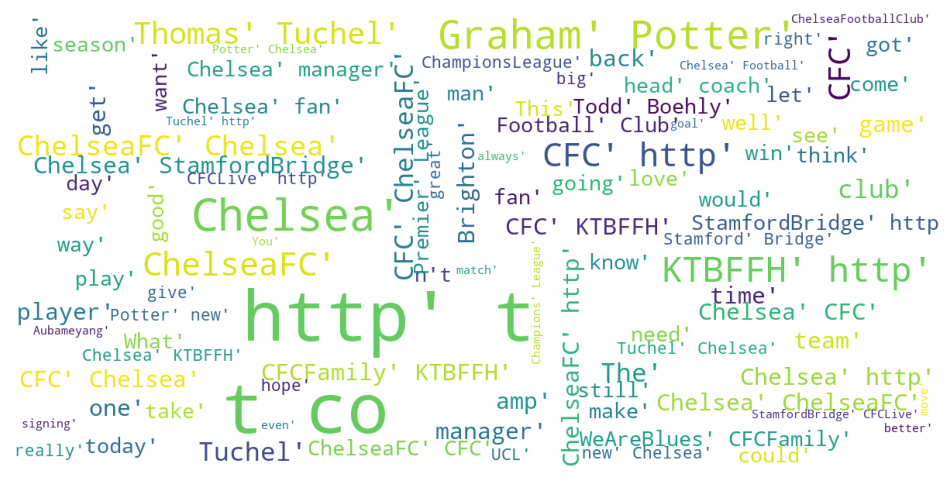

In [ ]:
plot_wordcloud(chelseaData['content'])

False    14560
True       679
Name: verified, dtype: int64


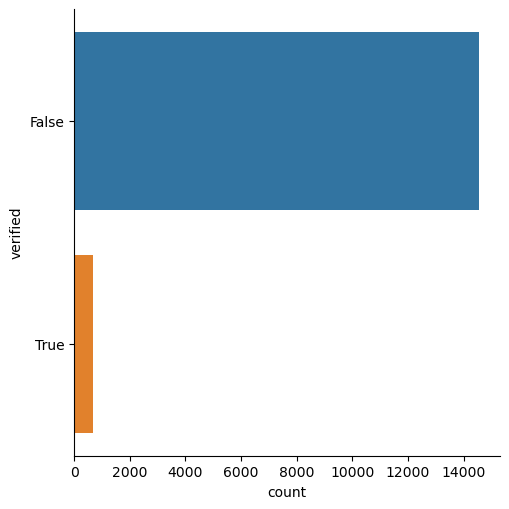

In [ ]:
print(chelseaData["verified"].value_counts())
sb.catplot(y = "verified", data = chelseaData, kind = "count")

Argentina              6282
Zimbabwe               3183
United States          3089
India                  1246
Kenya                   601
Japan                   250
Australia               220
Germany                 211
Brazil                   96
Peru                     23
Trinidad and Tobago      21
South Korea               5
Mexico                    4
France                    4
New Zealand               2
El Salvador               1
South Africa              1
Name: country, dtype: int64


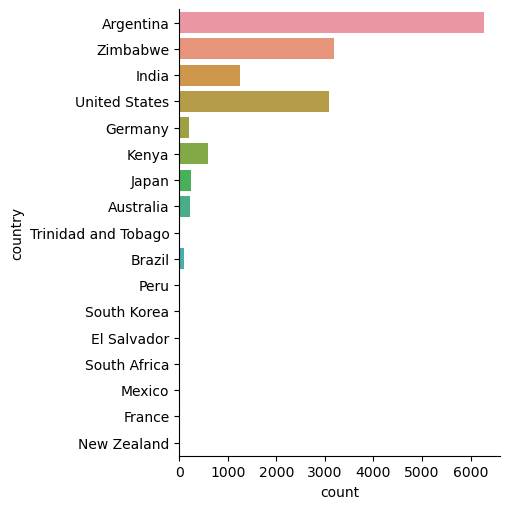

In [ ]:
print(chelseaData["country"].value_counts())
sb.catplot(y = "country", data = chelseaData, kind = "count")

 1    5477
-1    4888
 0    4874
Name: final_class, dtype: int64


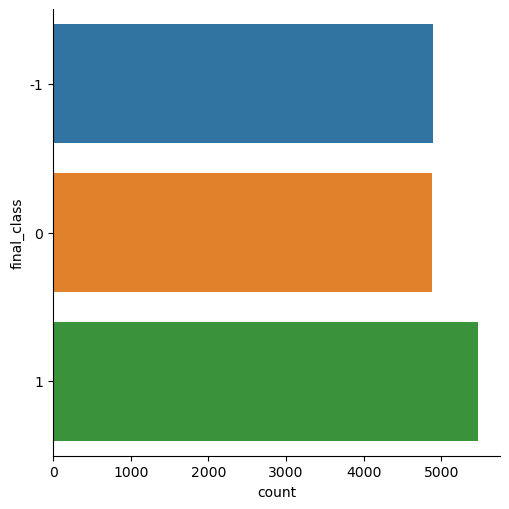

In [ ]:
print(chelseaData["final_class"].value_counts())
sb.catplot(y = "final_class", data = chelseaData, kind = "count")

## Arsenal

<AxesSubplot:>

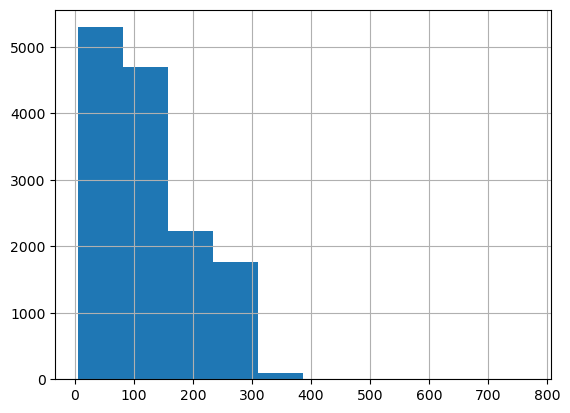

In [ ]:
arsenalData['content'].str.len().hist()

<AxesSubplot:>

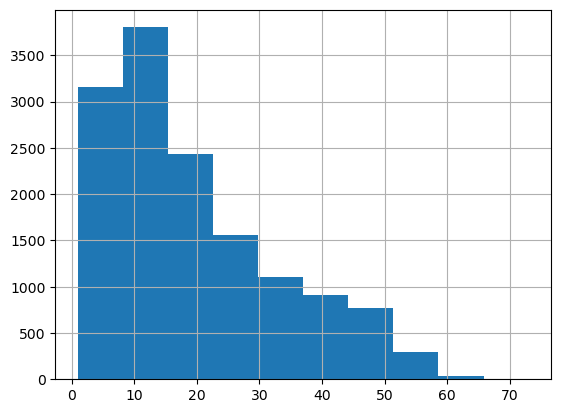

In [ ]:
arsenalData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

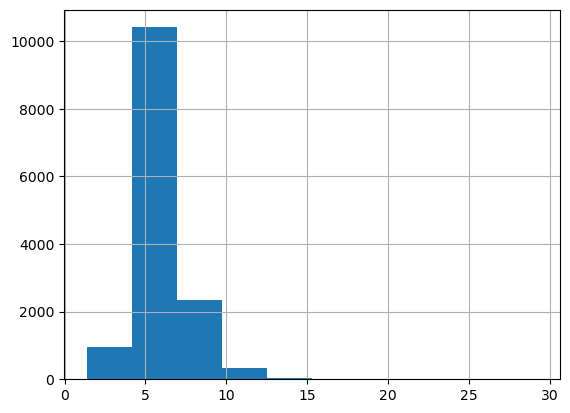

In [ ]:
arsenalData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

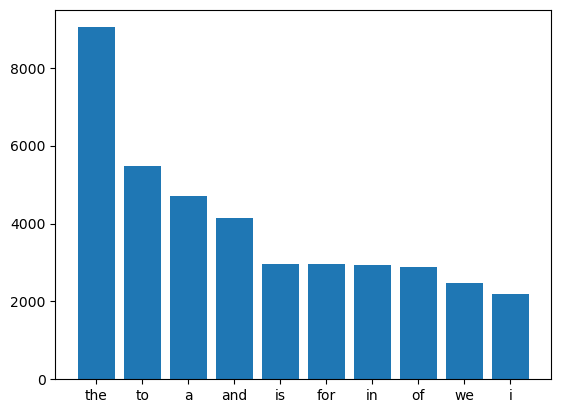

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= arsenalData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

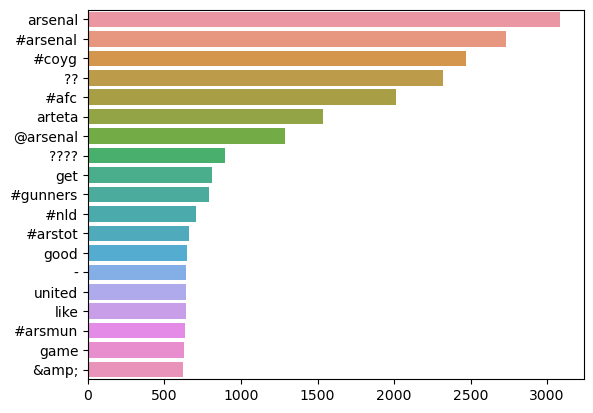

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

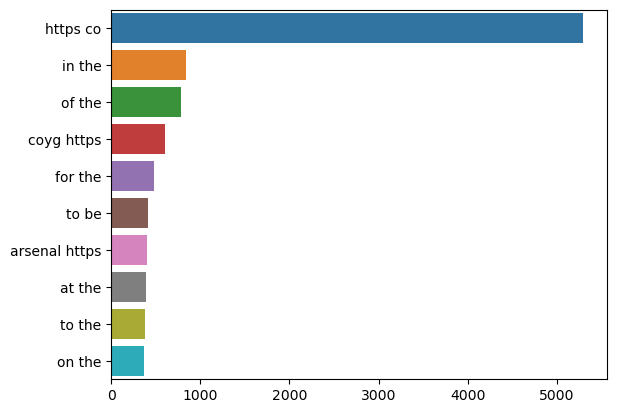

In [ ]:
plot_top_ngrams_barchart(arsenalData['content'],2)

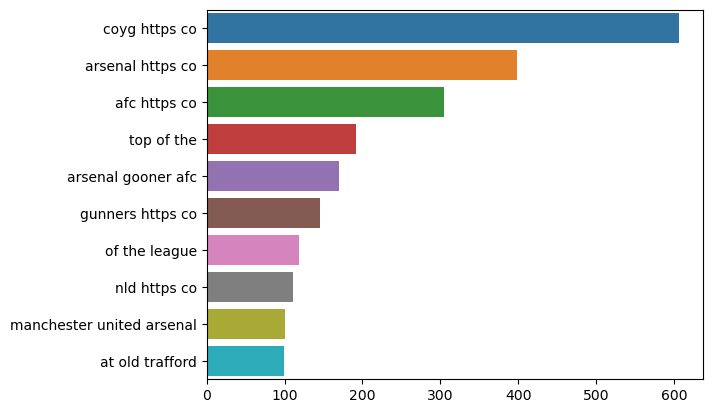

In [ ]:
plot_top_ngrams_barchart(arsenalData['content'],3)

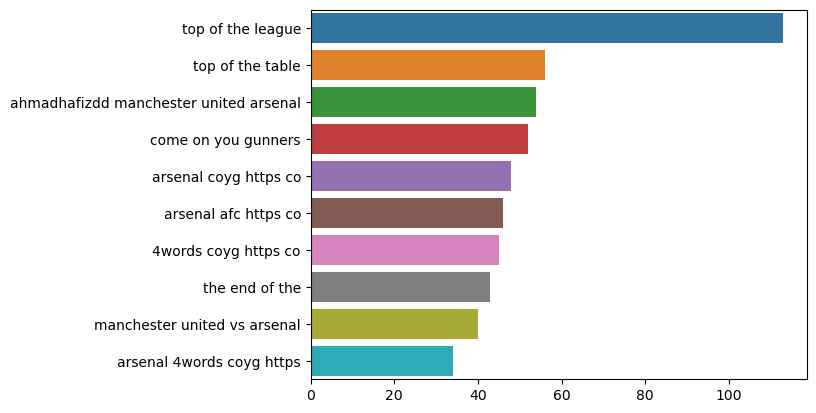

In [ ]:
plot_top_ngrams_barchart(arsenalData['content'],4)

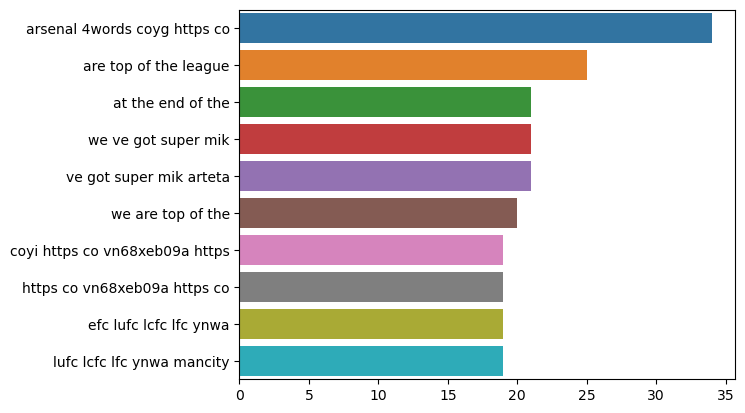

In [ ]:
plot_top_ngrams_barchart(arsenalData['content'],5)

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(arsenalData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.038*"http" + 0.030*"afc" + 0.025*"arsmun" + 0.023*"arsenal" + 0.007*"saka" + 0.007*"get" + 0.006*"goal" + 0.005*"gunner" + 0.005*"coyg" + 0.005*"game"'),
 (1,
  '0.048*"arsenal" + 0.048*"http" + 0.020*"coyg" + 0.013*"old" + 0.012*"afc" + 0.010*"united" + 0.009*"trafford" + 0.007*"manchester" + 0.007*"arteta" + 0.006*"ramsdale"'),
 (2,
  '0.029*"arsenal" + 0.025*"arteta" + 0.012*"player" + 0.011*"afc" + 0.010*"n\'t" + 0.009*"team" + 0.009*"get" + 0.009*"like" + 0.008*"season" + 0.007*"game"'),
 (3,
  '0.053*"http" + 0.024*"arsenal" + 0.021*"coyg" + 0.011*"afc" + 0.010*"great" + 0.010*"good" + 0.010*"gunner" + 0.006*"love" + 0.006*"happy" + 0.006*"let"'),
 (4,
  '0.062*"arsenal" + 0.060*"http" + 0.025*"coyg" + 0.014*"man" + 0.012*"gunner" + 0.010*"afc" + 0.009*"..." + 0.009*"win" + 0.008*"utd" + 0.008*"league"'),
 (5,
  '0.045*"nld" + 0.037*"http" + 0.031*"arstot" + 0.022*"arsenal" + 0.015*"coys" + 0.015*"london" + 0.012*"afc" + 0.011*"gooners" + 0.010*"coyg" + 0.010*"north"'),

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.202039  0.082886       1        1  31.068621
7     -0.108861  0.040787       2        1  10.317828
4      0.001132 -0.139515       3        1  10.266502
8     -0.074934 -0.043350       4        1   9.172134
0     -0.004809  0.078528       5        1   7.552761
9      0.008005 -0.068510       6        1   7.456949
5      0.133136 -0.014468       7        1   7.426119
1      0.009838 -0.062866       8        1   6.958006
3      0.082460 -0.024753       9        1   6.615213
6      0.156072  0.151261      10        1   3.165866, topic_info=         Term         Freq        Total Category  logprob  loglift
4        http  4599.000000  4599.000000  Default  30.0000  30.0000
18    arsenal  6939.000000  6939.000000  Default  29.0000  29.0000
107       nld   648.000000   648.000000  Default  28.0000  28.0000
37     arstot   560.000000   560.000000  Default  27.0000  27.0000
293    arsmun   570.000000   570.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
369      back    12.823171   524.223187  Topic10  -6.0568  -0.2579
547  m8arteta    11.896614   257.229289  Topic10  -6.1318   0.3790
31        see    11.775264   493.290103  Topic10  -6.1420  -0.2824
72      bring    11.025141   121.339530  Topic10  -6.2078   1.0543
140       get    11.294565   826.603596  Topic10  -6.1837  -0.8403

[747 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
848       1  0.551295      've
848       2  0.335846      've
848       4  0.050694      've
848       5  0.006337      've
848       6  0.019010      've
...     ...       ...      ...
579       7  0.108132  youtube
4666      3  0.070291     zaha
4666      4  0.913782     zaha
2147      6  0.923938    zrafc
1406      6  0.931040     £25m

[1840 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 5, 9, 1, 10, 6, 2, 4, 7])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


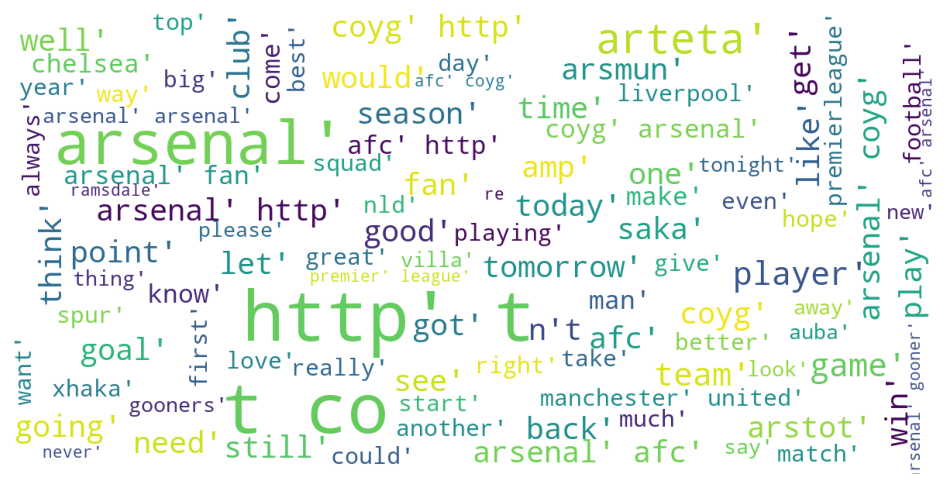

In [ ]:
plot_wordcloud(arsenalData['content'])

False    13690
True       381
Name: verified, dtype: int64


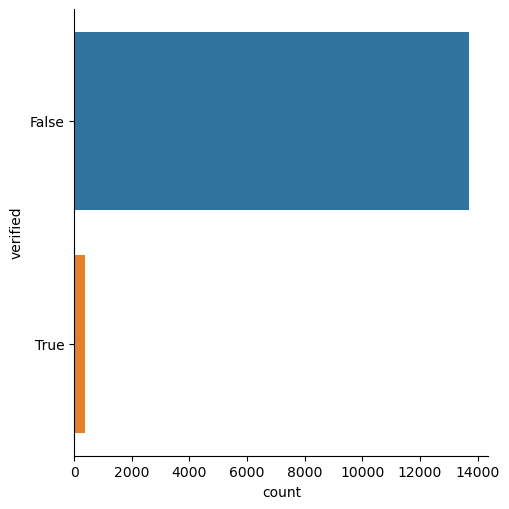

In [ ]:
print(arsenalData["verified"].value_counts())
sb.catplot(y = "verified", data = arsenalData, kind = "count")

Argentina         5533
United States     3449
India             2457
New Zealand        983
Brazil             817
South Africa       301
Australia          174
Egypt               80
Singapore           72
Uruguay             52
South Korea         39
Sweden              33
France              28
Mexico              27
United Kingdom      17
Belgium              3
Nigeria              2
Norway               1
Canada               1
Ireland              1
Netherlands          1
Name: country, dtype: int64


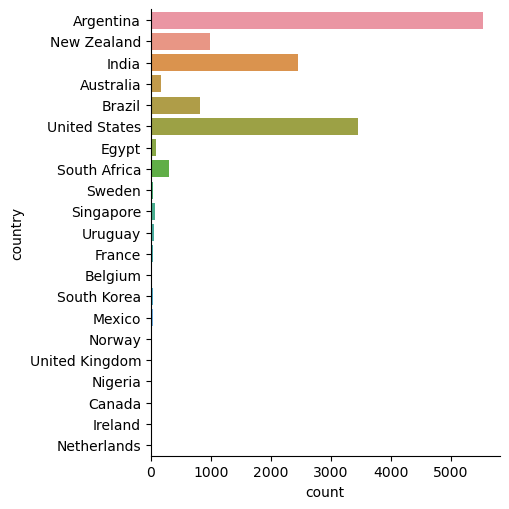

In [ ]:
print(arsenalData["country"].value_counts())
sb.catplot(y = "country", data = arsenalData, kind = "count")

 1    5388
-1    4602
 0    4081
Name: final_class, dtype: int64


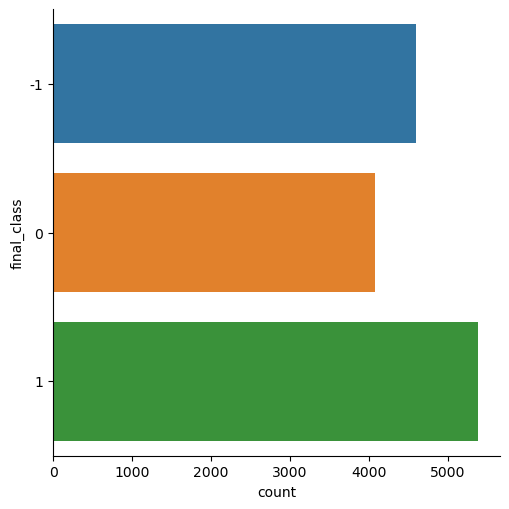

In [ ]:
print(arsenalData["final_class"].value_counts())
sb.catplot(y = "final_class", data = arsenalData, kind = "count")

## Liverpool

<AxesSubplot:>

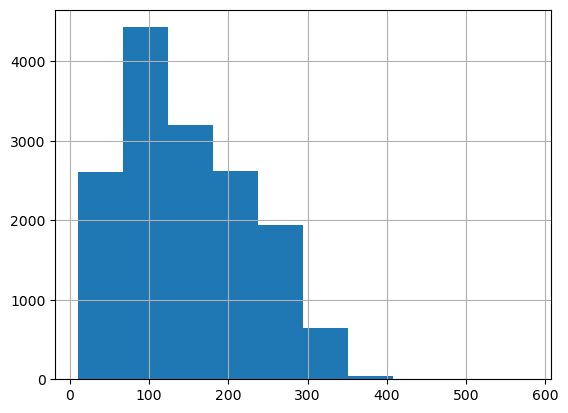

In [ ]:
liverpoolData['content'].str.len().hist()

<AxesSubplot:>

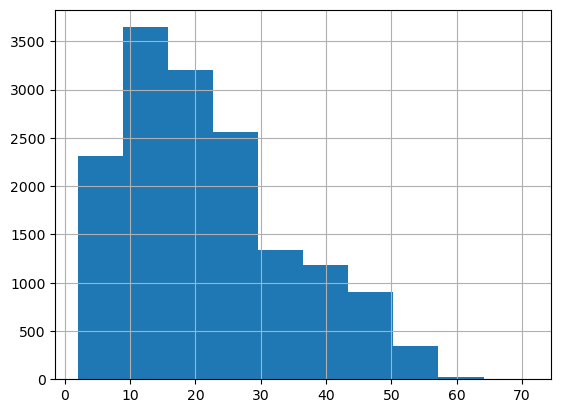

In [ ]:
liverpoolData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

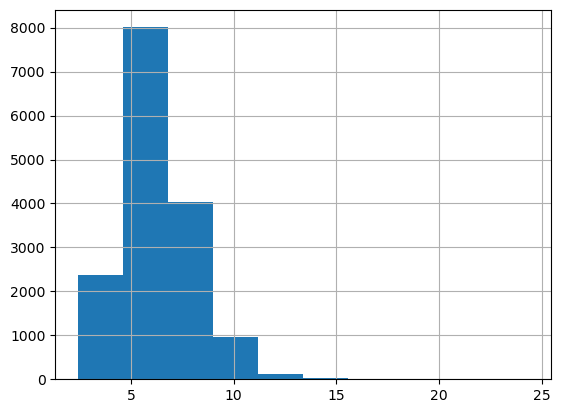

In [ ]:
liverpoolData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

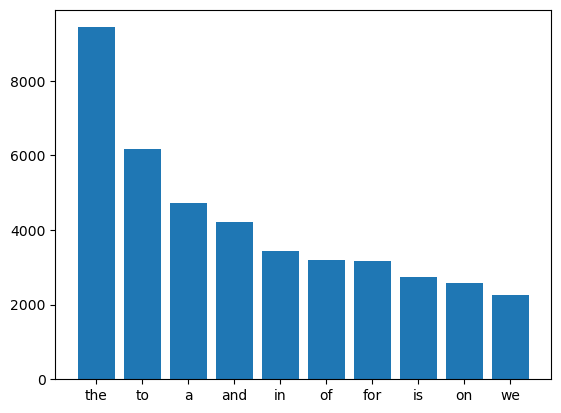

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= liverpoolData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

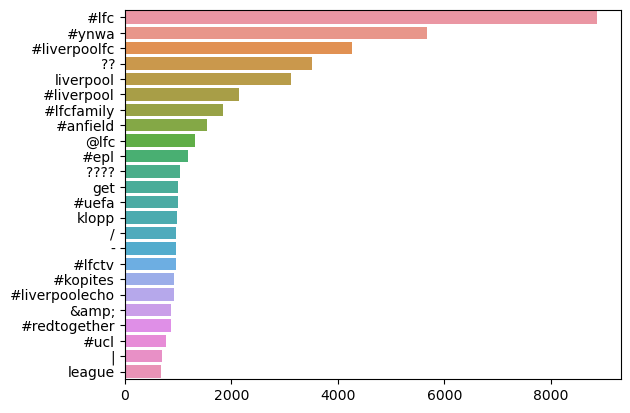

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

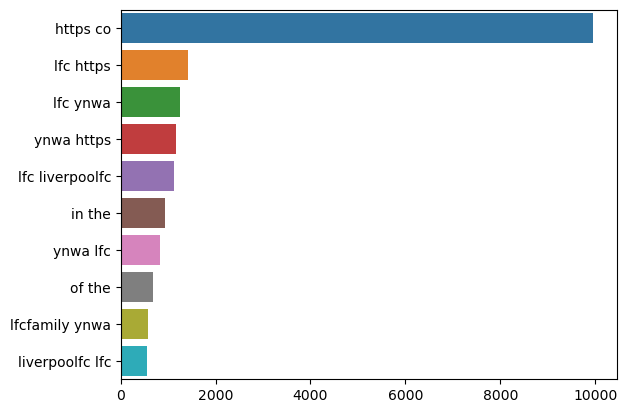

In [ ]:
plot_top_ngrams_barchart(liverpoolData['content'],2)

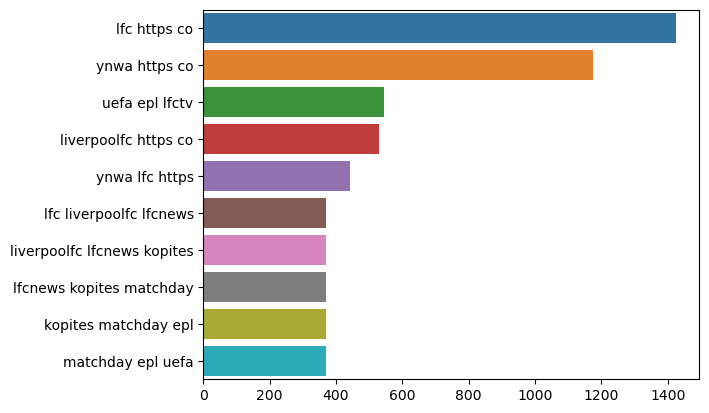

In [ ]:
plot_top_ngrams_barchart(liverpoolData['content'],3)

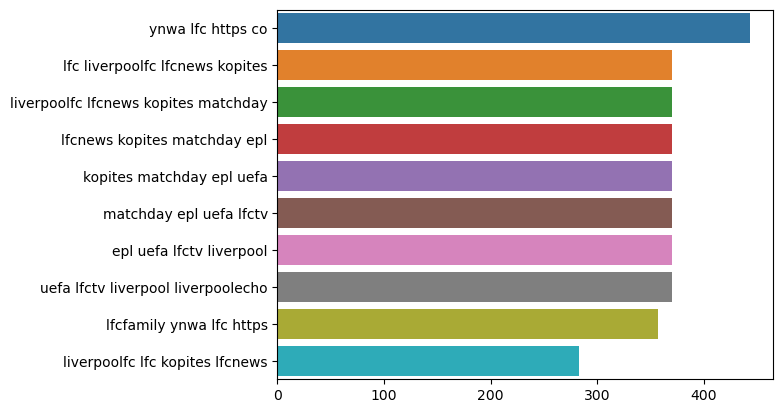

In [ ]:
plot_top_ngrams_barchart(liverpoolData['content'],4)

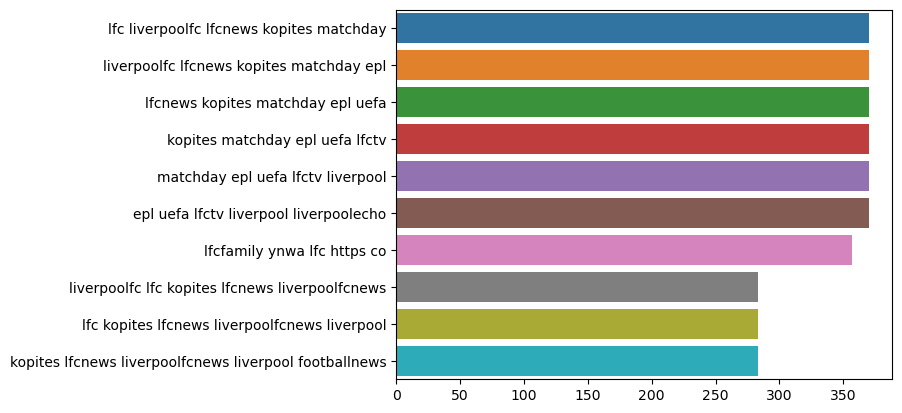

In [ ]:
plot_top_ngrams_barchart(liverpoolData['content'],5)

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(liverpoolData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.053*"lfc" + 0.023*"ynwa" + 0.016*"klopp" + 0.013*"season" + 0.012*"n\'t" + 0.011*"team" + 0.011*"liverpoolfc" + 0.010*"need" + 0.010*"player" + 0.010*"game"'),
 (1,
  '0.019*"ynwa" + 0.013*"van" + 0.011*"dijk" + 0.008*"lfc" + 0.008*"..." + 0.008*"virgil" + 0.008*"enjoy" + 0.007*"lfcfamily" + 0.007*"thanks" + 0.006*"rachel"'),
 (2,
  '0.046*"lfc" + 0.038*"http" + 0.026*"league" + 0.019*"ynwa" + 0.018*"champion" + 0.018*"liverpool" + 0.016*"ucl" + 0.010*"win" + 0.009*"game" + 0.008*"cup"'),
 (3,
  '0.068*"liverpool" + 0.044*"lfc" + 0.044*"liverpoolfc" + 0.043*"epl" + 0.042*"http" + 0.038*"lfctv" + 0.037*"uefa" + 0.036*"kopites" + 0.036*"liverpoolecho" + 0.030*"matchday"'),
 (4,
  '0.025*"ynwa" + 0.024*"http" + 0.015*"good" + 0.014*"liverpool" + 0.014*"..." + 0.012*"lfc" + 0.011*"game" + 0.010*"redtogether" + 0.009*"liverpoolfc" + 0.009*"city"'),
 (5,
  '0.036*"http" + 0.028*"liverpoolfc" + 0.017*"walk" + 0.015*"bet" + 0.013*"lfc" + 0.013*"ynwa" + 0.012*"football" + 0.012*"never

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.135183 -0.199090       1        1  25.858559
9     -0.099537 -0.022605       2        1  20.078317
3     -0.178583  0.177590       3        1  10.214912
7     -0.043168 -0.009309       4        1   8.817043
2     -0.027320 -0.010078       5        1   8.627128
5      0.098840  0.136664       6        1   7.143642
8      0.033796 -0.035980       7        1   6.412507
4      0.060014 -0.054642       8        1   4.915080
6      0.088755  0.093906       9        1   4.683954
1      0.202384 -0.076457      10        1   3.248856, topic_info=           Term         Freq        Total Category  logprob  loglift
4          http  9016.000000  9016.000000  Default  30.0000  30.0000
7     liverpool  5420.000000  5420.000000  Default  29.0000  29.0000
106         epl  1104.000000  1104.000000  Default  28.0000  28.0000
112       lfctv   886.000000   886.000000  Default  27.0000  27.0000
110     kopites   853.000000   853.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
6           lfc    62.881225  9943.581860  Topic10  -4.7752  -1.6366
1852       done    24.814616   167.915561  Topic10  -5.7050   1.5148
1957        pas    18.652868    49.914924  Topic10  -5.9904   2.4425
4          http    24.102992  9016.939394  Topic10  -5.7341  -2.4977
37         hope    19.243303   274.492562  Topic10  -5.9593   0.7691

[709 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
207       1  0.369755   'll
207       2  0.049004   'll
207       4  0.031184   'll
207       5  0.022274   'll
207       6  0.481127   'll
...     ...       ...   ...
384       9  0.942838   £€5
1106      9  0.980999  €£10
623       6  0.968926  €£20
1107      9  0.980999  €£30
624       6  0.968926   €£5

[1611 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 4, 8, 3, 6, 9, 5, 7, 2])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


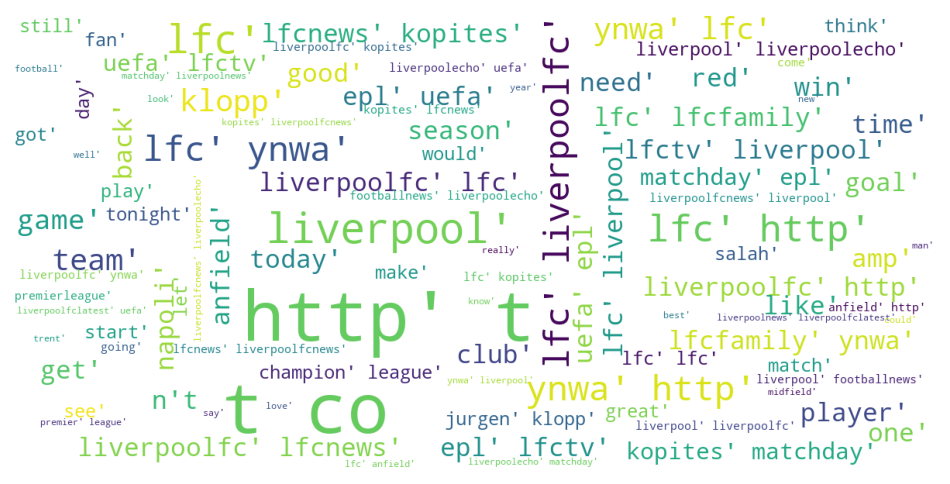

In [ ]:
plot_wordcloud(liverpoolData['content'])

False    14577
True       939
Name: verified, dtype: int64


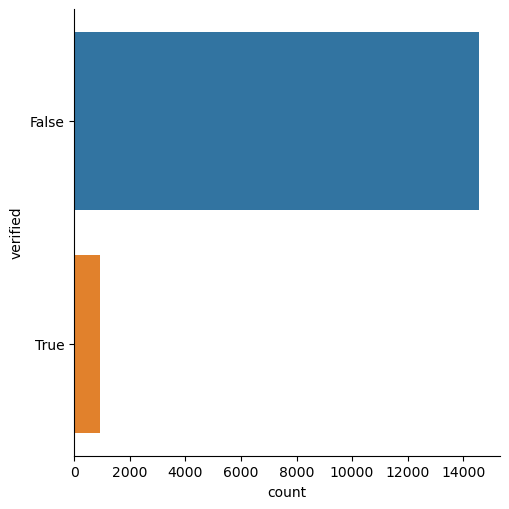

In [ ]:
print(liverpoolData["verified"].value_counts())
sb.catplot(y = "verified", data = liverpoolData, kind = "count")

Argentina              5930
Zimbabwe               3598
United States          2469
India                  1923
Kenya                   556
Germany                 407
Australia               219
Brazil                  185
Japan                   171
Trinidad and Tobago      28
Peru                     16
Canada                    7
United Kingdom            5
New Zealand               2
Name: country, dtype: int64


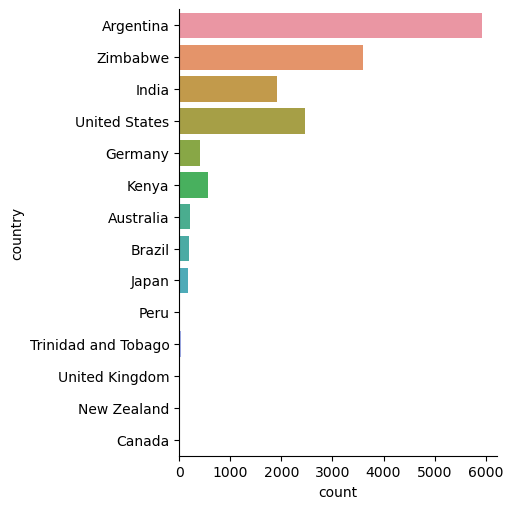

In [ ]:
print(liverpoolData["country"].value_counts())
sb.catplot(y = "country", data = liverpoolData, kind = "count")

 1    5532
-1    5118
 0    4866
Name: final_class, dtype: int64


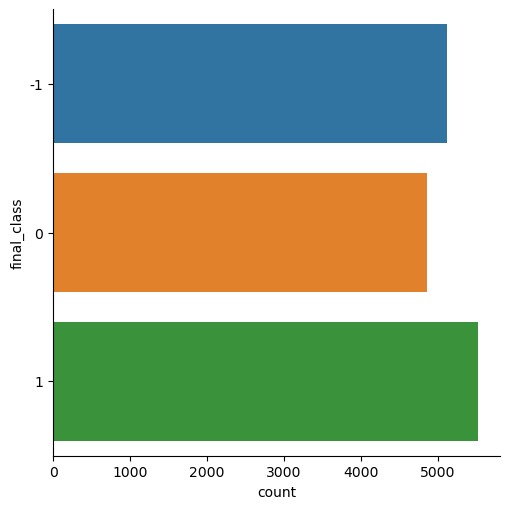

In [ ]:
print(liverpoolData["final_class"].value_counts())
sb.catplot(y = "final_class", data = liverpoolData, kind = "count")

## Tottenham 

<AxesSubplot:>

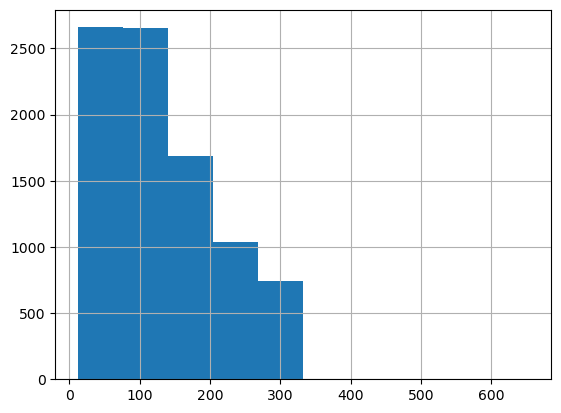

In [ ]:
totData['content'].str.len().hist()

<AxesSubplot:>

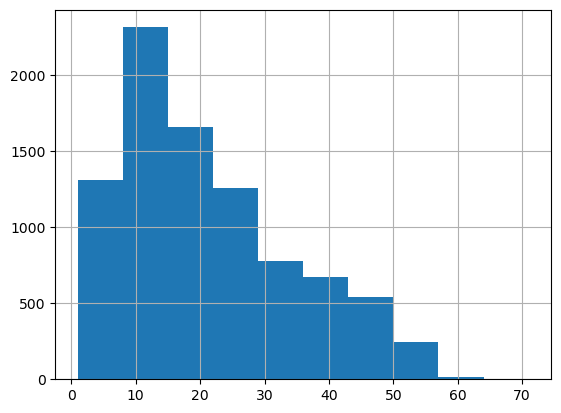

In [ ]:
totData['content'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

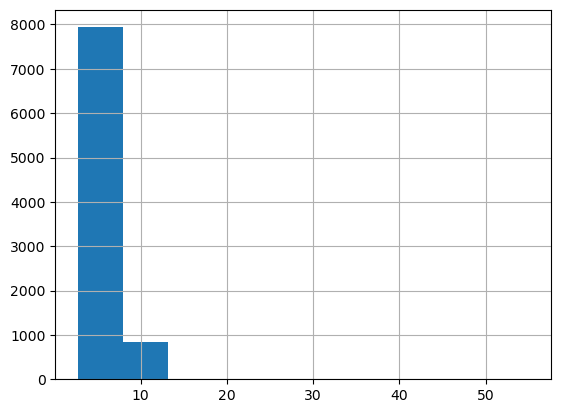

In [ ]:
totData['content'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

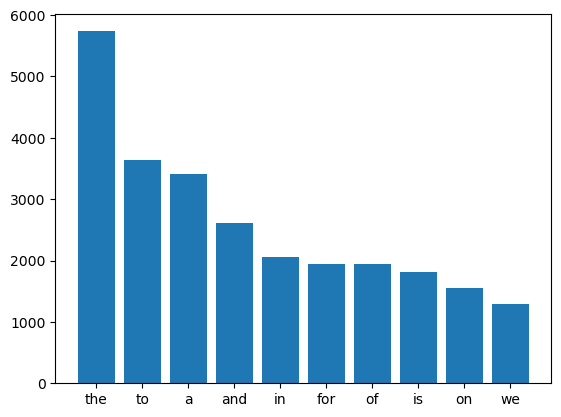

In [ ]:
# Plot the occurances of the most common stopwords in the dataset - create the corpus
corpus=[]
check= totData['content'].str.split()
check=check.values.tolist()
corpus=[word for i in check for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
mtplt.bar(x,y)
mtplt.show()

<AxesSubplot:>

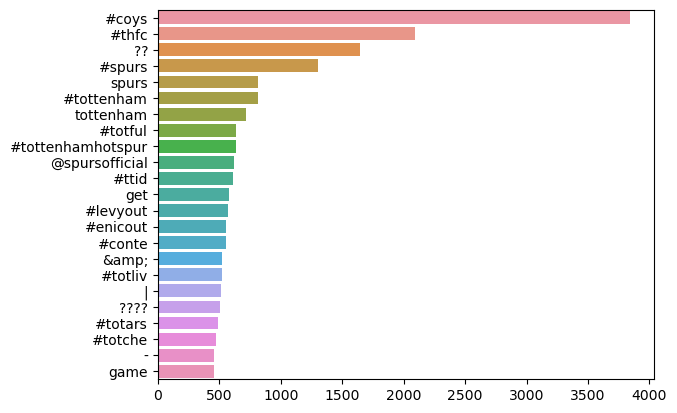

In [ ]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sb.barplot(x=y,y=x)

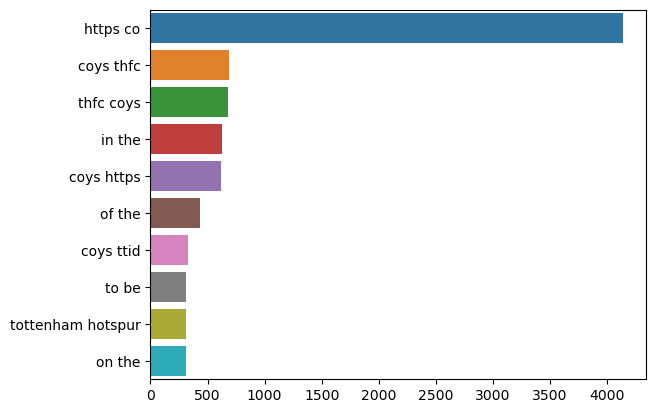

In [ ]:
plot_top_ngrams_barchart(totData['content'],2)

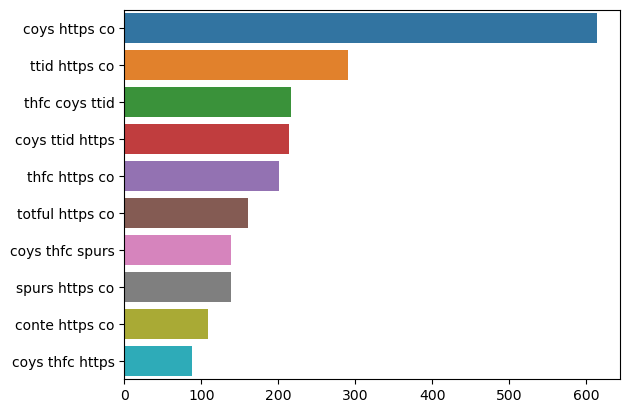

In [ ]:
plot_top_ngrams_barchart(totData['content'],3)

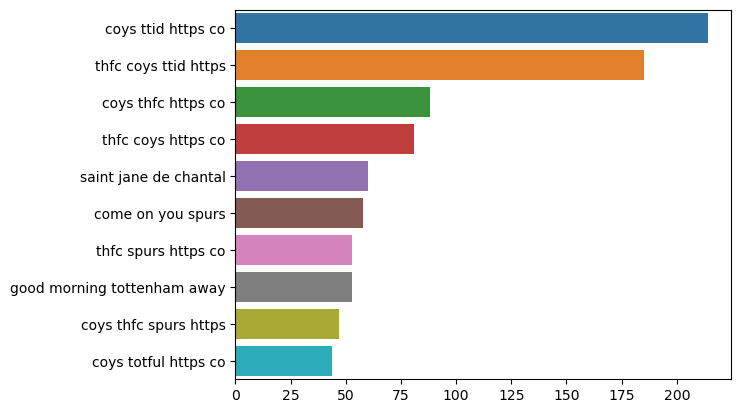

In [ ]:
plot_top_ngrams_barchart(totData['content'],4)

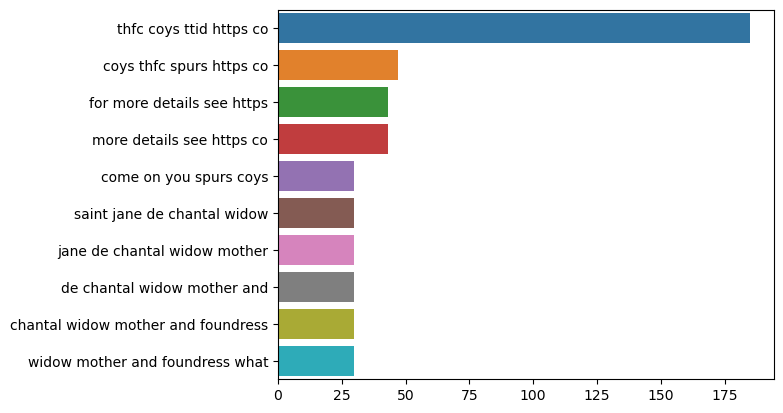

In [ ]:
plot_top_ngrams_barchart(totData['content'],5)

In [ ]:
lda_model, bow_corpus, dic = get_lda_objects(totData['content'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
lda_model.show_topics()

[(0,
  '0.030*"coys" + 0.021*"kane" + 0.017*"spur" + 0.017*"http" + 0.016*"thfc" + 0.012*"harry" + 0.012*"tottenham" + 0.011*"conte" + 0.010*"half" + 0.007*"better"'),
 (1,
  '0.040*"http" + 0.037*"coys" + 0.026*"spur" + 0.016*"thfc" + 0.013*"tottenhamhotspur" + 0.011*"spursofficial" + 0.011*"totars" + 0.010*"tottenham" + 0.009*"son" + 0.008*"conte"'),
 (2,
  '0.060*"coys" + 0.027*"thfc" + 0.022*"spur" + 0.020*"http" + 0.015*"game" + 0.014*"today" + 0.011*"good" + 0.010*"totche" + 0.009*"goal" + 0.009*"win"'),
 (3,
  '0.038*"tottenham" + 0.038*"http" + 0.024*"coys" + 0.019*"league" + 0.015*"hotspur" + 0.015*"premier" + 0.015*"thfc" + 0.012*"kane" + 0.011*"fulham" + 0.011*"ham"'),
 (4,
  '0.050*"http" + 0.024*"spur" + 0.023*"coys" + 0.017*"tottenham" + 0.017*"thfc" + 0.011*"conte" + 0.010*"totful" + 0.009*"game" + 0.008*"fulham" + 0.008*"premierleague"'),
 (5,
  '0.052*"http" + 0.048*"coys" + 0.024*"thfc" + 0.018*"spur" + 0.013*"conte" + 0.011*"ttid" + 0.008*"first" + 0.007*"spursoffici

In [ ]:
# Can adjust the metric value, as well as the topics
plot_lda_vis(lda_model, bow_corpus, dic)

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.076893 -0.058168       1        1  19.434513
4      0.011014 -0.045458       2        1  13.642552
8      0.082996  0.050442       3        1  12.083773
5      0.100809 -0.009193       4        1  11.151689
1      0.058735  0.035035       5        1   9.007542
0      0.020700 -0.040153       6        1   8.581091
9     -0.002789  0.043977       7        1   8.273031
3     -0.045704 -0.071985       8        1   7.910544
7     -0.110713  0.192675       9        1   6.071893
6     -0.191939 -0.097174      10        1   3.843370, topic_info=              Term         Freq        Total Category  logprob  loglift
13         enicout   511.000000   511.000000  Default  30.0000  30.0000
33         levyout   506.000000   506.000000  Default  29.0000  29.0000
91       tottenham  1398.000000  1398.000000  Default  28.0000  28.0000
281         totliv   488.000000   488.000000  Default  27.0000  27.0000
2             http  3515.000000  3515.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
338           game    23.200119   761.995255  Topic10  -5.2605  -0.2330
36   spursofficial    21.574080   624.304601  Topic10  -5.3332  -0.1063
90            thfc    22.931080  1907.854740  Topic10  -5.2722  -1.1624
281         totliv    18.965785   488.347018  Topic10  -5.4620   0.0104
123            amp    18.235088   425.998875  Topic10  -5.5013   0.1077

[758 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
466       2  0.128175      'll
466       4  0.288393      'll
466       5  0.032044      'll
466       6  0.448611      'll
466       9  0.112153      'll
...     ...       ...      ...
3274      5  0.129020  youtube
3274      6  0.110589  youtube
900       7  0.960421   zombie
3169      7  0.939033     zone
8513      9  0.806109     £10m

[1719 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 9, 6, 2, 1, 10, 4, 8, 7])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


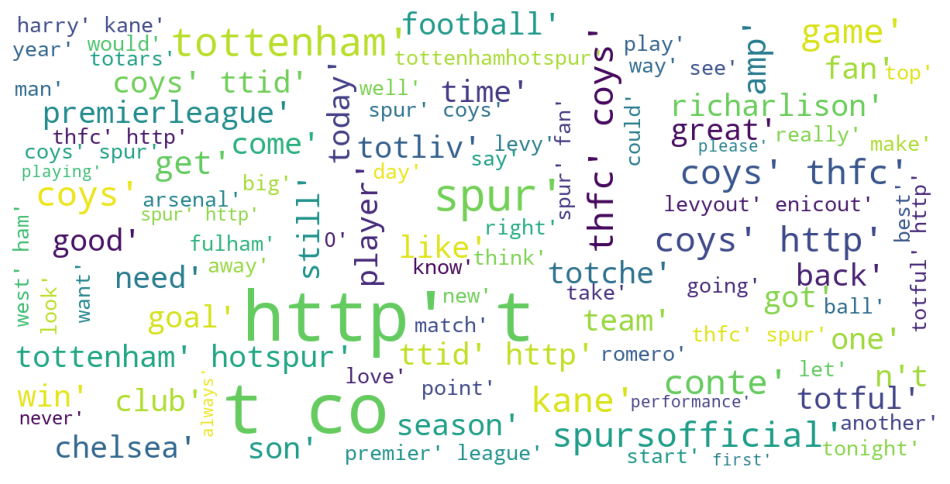

In [ ]:
plot_wordcloud(totData['content'])

False    8420
True      367
Name: verified, dtype: int64


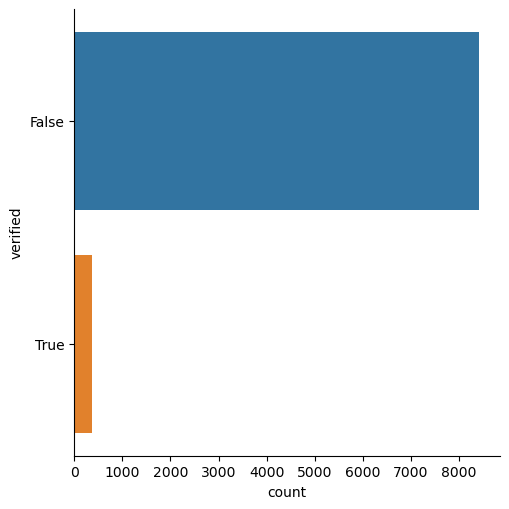

In [ ]:
print(totData["verified"].value_counts())
sb.catplot(y = "verified", data = totData, kind = "count")

Argentina         5190
United States     2161
South Africa       501
Australia          326
India              292
Brazil              84
Singapore           66
United Kingdom      54
Italy               29
Ireland             23
Mexico              22
Germany             13
Norway               8
Sweden               7
Uruguay              6
South Korea          2
New Zealand          2
Portugal             1
Name: country, dtype: int64


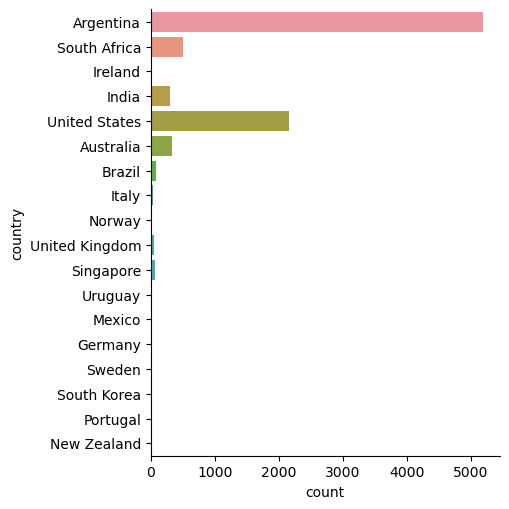

In [ ]:
print(totData["country"].value_counts())
sb.catplot(y = "country", data = totData, kind = "count")

 1    3112
 0    2861
-1    2814
Name: final_class, dtype: int64


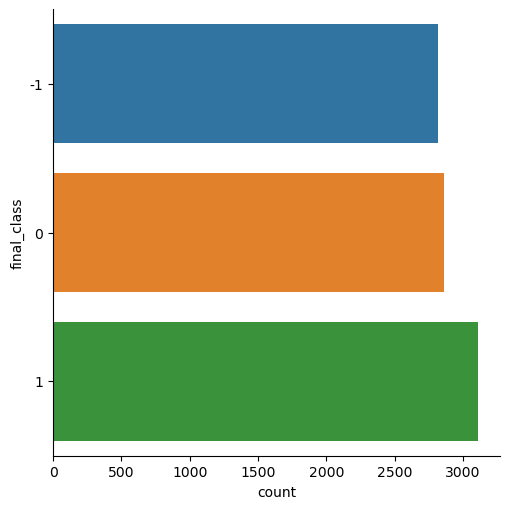

In [ ]:
print(totData["final_class"].value_counts())
sb.catplot(y = "final_class", data = totData, kind = "count")